# SLAMseq

## Installing slamdunk (only do once)

In [1]:
# install slamdunk
#! pip3 install git+https://github.com/jkobject/slamdunk.git --upgrade

In [2]:
# clone and install genepy
# pip install -e genepy

In [3]:
# please also install cutadapt, fastqc, and trimgalore
#! conda install -c bioconda cutadapt
#! conda install -c bioconda fastqc
#! conda install -c bioconda trim-galore

In [1]:
from __future__ import print_function
import os.path
import pandas as pd
import sys
sys.path.insert(0, '../../')
import seaborn as sns
import numpy as np
from natsort import os_sorted

from genepy.utils import helper as h
from genepy.utils import plot as genepyPlot
from genepy.rna import pyDESeq2
import genepy.rna as rna

In [3]:
from bokeh.plotting import *
from bokeh.models import HoverTool
from bokeh.io import output_notebook

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
#from umap import UMAP

output_notebook()
%load_ext autoreload
%matplotlib inline
%autoreload 2
%load_ext rpy2.ipython

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [4]:
def createDir(directory):
    if not os.path.exists(directory):
        print("Creating output directory: " + directory)
        os.makedirs(directory)

# MYB-dTAG in multiple cell lines

SLAMseq of MYB-dTag in multiple cell lines (MV411, MONOMAC1, NOMO1, P31FUJ, THP1)
<br>All MYB CT degrons with P2A sequence between degron and FP
<br>1h degradation + 1h 4sU with 0.5$\mu$M VHL (with ERCC spike-in control)
<br>__Processed without alt loci__

In [5]:
project = "MYB_degraded_lines_v1"

In [6]:
location = "../data/slamseq_"+project+"/" # new data location

## download the data

In [9]:
location = "../data/slamseq_"+project+"/" # new data location
loc = "220602_MP10090_fastq" # transfer AML folder

In [10]:
! mkdir ../$location
! mkdir ../results/slamseq_$project
! mkdir $location && mkdir $location/qc # make data dir in AMLproject
! mkdir ../$location/fastqs/ # make dir in /home/monika/data/project/fastqs

In [34]:
! gsutil ls gs://transfer-amlproject/$loc/

gs://transfer-amlproject/220602_MP10090_fastq/20220602_10_MYB-dTAG_1h_MONOMAC1_DMSO_B_MP10090_S56_R1_001.fastq.gz
gs://transfer-amlproject/220602_MP10090_fastq/20220602_10_MYB-dTAG_1h_MONOMAC1_DMSO_B_MP10090_S56_R2_001.fastq.gz
gs://transfer-amlproject/220602_MP10090_fastq/20220602_11_MYB-dTAG_1h_MONOMAC1_DMSO_C_MP10090_S57_R1_001.fastq.gz
gs://transfer-amlproject/220602_MP10090_fastq/20220602_11_MYB-dTAG_1h_MONOMAC1_DMSO_C_MP10090_S57_R2_001.fastq.gz
gs://transfer-amlproject/220602_MP10090_fastq/20220602_12_MYB-dTAG_1h_MONOMAC1_DMSO_D_MP10090_S58_R1_001.fastq.gz
gs://transfer-amlproject/220602_MP10090_fastq/20220602_12_MYB-dTAG_1h_MONOMAC1_DMSO_D_MP10090_S58_R2_001.fastq.gz
gs://transfer-amlproject/220602_MP10090_fastq/20220602_13_MYB-dTAG_1h_MONOMAC1_VHL_A_MP10090_S59_R1_001.fastq.gz
gs://transfer-amlproject/220602_MP10090_fastq/20220602_13_MYB-dTAG_1h_MONOMAC1_VHL_A_MP10090_S59_R2_001.fastq.gz
gs://transfer-amlproject/220602_MP10090_fastq/20220602_14_MYB-dTAG_1h_MONOMAC1_VHL_B_MP100

In [33]:
! gsutil ls gs://transfer-amlproject/*fastq.gz

gs://transfer-amlproject/20220602_16_MYB-dTAG_1h_MONOMAC1_VHL_D_MP10090_S62_R1_001.fastq.gz
gs://transfer-amlproject/20220602_16_MYB-dTAG_1h_MONOMAC1_VHL_D_MP10090_S62_R2_001.fastq.gz


In [32]:
! gsutil -m cp gs://transfer-amlproject/*fastq.gz gs://transfer-amlproject/$loc/

Copying gs://transfer-amlproject/20220602_16_MYB-dTAG_1h_MONOMAC1_VHL_D_MP10090_S62_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Copying gs://transfer-amlproject/20220602_16_MYB-dTAG_1h_MONOMAC1_VHL_D_MP10090_S62_R2_001.fastq.gz [Content-Type=application/octet-stream]...
/ [2/2 files][  6.9 GiB/  6.9 GiB] 100% Done                                    
Operation completed over 2 objects/6.9 GiB.                                      


In [12]:
# transfer qc files
! gsutil -m cp gs://transfer-amlproject/$loc/multiqc_report.html $location/qc/
! gsutil -m cp -r gs://transfer-amlproject/$loc/Reports/ $location/qc/
! gsutil -m cp -r gs://transfer-amlproject/$loc/multiqc_data/ $location/qc/

Copying gs://transfer-amlproject/220602_MP10090_fastq/multiqc_report.html...
/ [1/1 files][  2.0 MiB/  2.0 MiB] 100% Done                                    
Operation completed over 1 objects/2.0 MiB.                                      
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_10_MYB-dTAG_1h_MONOMAC1_DMSO_B_MP10090_S56_R1_001_fastqc.html...
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_10_MYB-dTAG_1h_MONOMAC1_DMSO_B_MP10090_S56_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_10_MYB-dTAG_1h_MONOMAC1_DMSO_B_MP10090_S56_R2_001_fastqc.html...
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_11_MYB-dTAG_1h_MONOMAC1_DMSO_C_MP10090_S57_R2_001_fastqc.html...
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_10_MYB-dTAG_1h_MONOMAC1_DMSO_B_MP10090_S56_R2_001_fastqc.zip...
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_11_MYB-dTAG

Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_24_MYB-dTAG_1h_NOMO1_VHL_D_MP10090_S70_R2_001_fastqc.zip...
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_25_MYB-dTAG_1h_P31FUJ_DMSO_A_MP10090_S71_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_25_MYB-dTAG_1h_P31FUJ_DMSO_A_MP10090_S71_R2_001_fastqc.zip...
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_25_MYB-dTAG_1h_P31FUJ_DMSO_A_MP10090_S71_R2_001_fastqc.html...
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_26_MYB-dTAG_1h_P31FUJ_DMSO_B_MP10090_S72_R1_001_fastqc.html...
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_26_MYB-dTAG_1h_P31FUJ_DMSO_B_MP10090_S72_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_26_MYB-dTAG_1h_P31FUJ_DMSO_B_MP10090_S72_R2_001_fastqc.html...
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/202206

Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_40_MYB-dTAG_1h_THP1_VHL_D_MP10090_S86_R1_001_fastqc.html...
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_40_MYB-dTAG_1h_THP1_VHL_D_MP10090_S86_R2_001_fastqc.zip...
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_40_MYB-dTAG_1h_THP1_VHL_D_MP10090_S86_R2_001_fastqc.html...
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_4_MYB-dTAG_1h_MV411_DMSO_D_MP10090_S51_R1_001_fastqc.html...
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_4_MYB-dTAG_1h_MV411_DMSO_D_MP10090_S51_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_4_MYB-dTAG_1h_MV411_DMSO_D_MP10090_S51_R2_001_fastqc.html...
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_4_MYB-dTAG_1h_MV411_DMSO_D_MP10090_S51_R2_001_fastqc.zip...
Copying gs://transfer-amlproject/220602_MP10090_fastq/Reports/20220602_5_MYB-dTAG_

In [13]:
! cp $location/qc/multiqc_report.html ../results/slamseq_$project

In [35]:
fastqs = ! gsutil ls gs://transfer-amlproject/$loc/*.gz

add sample names to AML sample tracker google sheet (RNA_tracker_JK)

__6_MYB-dTAG_1h_MV411_VHL_B__: failed initial QC (not enough RNA)

In [36]:
print(len(fastqs))
[f.split("_R")[0] for f in fastqs[::2]]

78


['gs://transfer-amlproject/220602_MP10090_fastq/20220602_10_MYB-dTAG_1h_MONOMAC1_DMSO_B_MP10090_S56',
 'gs://transfer-amlproject/220602_MP10090_fastq/20220602_11_MYB-dTAG_1h_MONOMAC1_DMSO_C_MP10090_S57',
 'gs://transfer-amlproject/220602_MP10090_fastq/20220602_12_MYB-dTAG_1h_MONOMAC1_DMSO_D_MP10090_S58',
 'gs://transfer-amlproject/220602_MP10090_fastq/20220602_13_MYB-dTAG_1h_MONOMAC1_VHL_A_MP10090_S59',
 'gs://transfer-amlproject/220602_MP10090_fastq/20220602_14_MYB-dTAG_1h_MONOMAC1_VHL_B_MP10090_S60',
 'gs://transfer-amlproject/220602_MP10090_fastq/20220602_15_MYB-dTAG_1h_MONOMAC1_VHL_C_MP10090_S61',
 'gs://transfer-amlproject/220602_MP10090_fastq/20220602_16_MYB-dTAG_1h_MONOMAC1_VHL_D_MP10090_S62',
 'gs://transfer-amlproject/220602_MP10090_fastq/20220602_17_MYB-dTAG_1h_NOMO1_DMSO_A_MP10090_S63',
 'gs://transfer-amlproject/220602_MP10090_fastq/20220602_18_MYB-dTAG_1h_NOMO1_DMSO_B_MP10090_S64',
 'gs://transfer-amlproject/220602_MP10090_fastq/20220602_19_MYB-dTAG_1h_NOMO1_DMSO_C_MP10090

In [40]:
fastqs = [fastq.split("/")[-1] for fastq in os_sorted(fastqs)]
# add sample names to AML sample tracker google sheet
for val1, val2 in h.grouped(fastqs, 2):
    print(val1.split("_R")[0])

20220602_1_MYB-dTAG_1h_MV411_DMSO_A_MP10090_S48
20220602_2_MYB-dTAG_1h_MV411_DMSO_B_MP10090_S49
20220602_3_MYB-dTAG_1h_MV411_DMSO_C_MP10090_S50
20220602_4_MYB-dTAG_1h_MV411_DMSO_D_MP10090_S51
20220602_5_MYB-dTAG_1h_MV411_VHL_A_MP10090_S52
20220602_7_MYB-dTAG_1h_MV411_VHL_C_MP10090_S53
20220602_8_MYB-dTAG_1h_MV411_VHL_D_MP10090_S54
20220602_9_MYB-dTAG_1h_MONOMAC1_DMSO_A_MP10090_S55
20220602_10_MYB-dTAG_1h_MONOMAC1_DMSO_B_MP10090_S56
20220602_11_MYB-dTAG_1h_MONOMAC1_DMSO_C_MP10090_S57
20220602_12_MYB-dTAG_1h_MONOMAC1_DMSO_D_MP10090_S58
20220602_13_MYB-dTAG_1h_MONOMAC1_VHL_A_MP10090_S59
20220602_14_MYB-dTAG_1h_MONOMAC1_VHL_B_MP10090_S60
20220602_15_MYB-dTAG_1h_MONOMAC1_VHL_C_MP10090_S61
20220602_16_MYB-dTAG_1h_MONOMAC1_VHL_D_MP10090_S62
20220602_17_MYB-dTAG_1h_NOMO1_DMSO_A_MP10090_S63
20220602_18_MYB-dTAG_1h_NOMO1_DMSO_B_MP10090_S64
20220602_19_MYB-dTAG_1h_NOMO1_DMSO_C_MP10090_S65
20220602_20_MYB-dTAG_1h_NOMO1_DMSO_D_MP10090_S66
20220602_21_MYB-dTAG_1h_NOMO1_VHL_A_MP10090_S67
20220602_22_

In [41]:
# transfer fastqs
! gsutil -m cp gs://transfer-amlproject/$loc/*.fastq.gz ../$location/fastqs/

Copying gs://transfer-amlproject/220602_MP10090_fastq/20220602_11_MYB-dTAG_1h_MONOMAC1_DMSO_C_MP10090_S57_R1_001.fastq.gz...
Copying gs://transfer-amlproject/220602_MP10090_fastq/20220602_10_MYB-dTAG_1h_MONOMAC1_DMSO_B_MP10090_S56_R2_001.fastq.gz...
Copying gs://transfer-amlproject/220602_MP10090_fastq/20220602_10_MYB-dTAG_1h_MONOMAC1_DMSO_B_MP10090_S56_R1_001.fastq.gz...
Copying gs://transfer-amlproject/220602_MP10090_fastq/20220602_11_MYB-dTAG_1h_MONOMAC1_DMSO_C_MP10090_S57_R2_001.fastq.gz...
Copying gs://transfer-amlproject/220602_MP10090_fastq/20220602_12_MYB-dTAG_1h_MONOMAC1_DMSO_D_MP10090_S58_R1_001.fastq.gz...
Copying gs://transfer-amlproject/220602_MP10090_fastq/20220602_12_MYB-dTAG_1h_MONOMAC1_DMSO_D_MP10090_S58_R2_001.fastq.gz...
Copying gs://transfer-amlproject/220602_MP10090_fastq/20220602_13_MYB-dTAG_1h_MONOMAC1_VHL_A_MP10090_S59_R2_001.fastq.gz...
Copying gs://transfer-amlproject/220602_MP10090_fastq/20220602_14_MYB-dTAG_1h_MONOMAC1_VHL_B_MP10090_S60_R1_001.fastq.gz...
Co

## rename local fastqs

In [60]:
fastq_folder = "../"+location+"fastqs"
print(fastq_folder)
fastqs = ! ls $fastq_folder
fastqs = os_sorted(fastqs)
fastqs

../../data/slamseq_MYB_degraded_lines_v1/fastqs


['20220602_1_MYB-dTAG_1h_MV411_DMSO_A_MP10090_S48_R1_001.fastq.gz',
 '20220602_1_MYB-dTAG_1h_MV411_DMSO_A_MP10090_S48_R2_001.fastq.gz',
 '20220602_2_MYB-dTAG_1h_MV411_DMSO_B_MP10090_S49_R1_001.fastq.gz',
 '20220602_2_MYB-dTAG_1h_MV411_DMSO_B_MP10090_S49_R2_001.fastq.gz',
 '20220602_3_MYB-dTAG_1h_MV411_DMSO_C_MP10090_S50_R1_001.fastq.gz',
 '20220602_3_MYB-dTAG_1h_MV411_DMSO_C_MP10090_S50_R2_001.fastq.gz',
 '20220602_4_MYB-dTAG_1h_MV411_DMSO_D_MP10090_S51_R1_001.fastq.gz',
 '20220602_4_MYB-dTAG_1h_MV411_DMSO_D_MP10090_S51_R2_001.fastq.gz',
 '20220602_5_MYB-dTAG_1h_MV411_VHL_A_MP10090_S52_R1_001.fastq.gz',
 '20220602_5_MYB-dTAG_1h_MV411_VHL_A_MP10090_S52_R2_001.fastq.gz',
 '20220602_7_MYB-dTAG_1h_MV411_VHL_C_MP10090_S53_R1_001.fastq.gz',
 '20220602_7_MYB-dTAG_1h_MV411_VHL_C_MP10090_S53_R2_001.fastq.gz',
 '20220602_8_MYB-dTAG_1h_MV411_VHL_D_MP10090_S54_R1_001.fastq.gz',
 '20220602_8_MYB-dTAG_1h_MV411_VHL_D_MP10090_S54_R2_001.fastq.gz',
 '20220602_9_MYB-dTAG_1h_MONOMAC1_DMSO_A_MP10090_S55_R

In [47]:
from gsheets import Sheets
sheets = Sheets.from_files('~/.client_secret_web.json', '~/.storage.json')
url = "https://docs.google.com/spreadsheets/d/1yFLjYB1McU530JnLgL0QIMAKIkVl3kl0_LCHje2gk8U/edit?ts=5fab1071#gid=738732237"
gsheet = sheets.get(url).sheets[12].to_frame()

In [61]:
len(fastqs)/2

39.0

In [70]:
# get new sample names from AML sample tracker - RNA_tracker_JK
idx = gsheet.index[gsheet['batch'] == project] # get first row with project number
sample_info = gsheet.loc[idx[0]:, ["prev_name", "name"]]
sample_info = sample_info.iloc[:int(len(fastqs)/2),]

In [71]:
# make dict with names
rename = dict(zip(sample_info.prev_name, sample_info.name))

# rename fastqs locally
for val in fastqs:
    rep  = val
    for old, new in rename.items():
        rep = rep.replace(old, new)
    if rep != val:
        ! mv $fastq_folder/$val $fastq_folder/$rep

# Processing

In [7]:
project

'MYB_degraded_lines_v1'

In [8]:
fastq_folder = "../"+location+"fastqs"
print(fastq_folder)
fastqs = ! ls $fastq_folder/*fastq.gz
print(len(fastqs[::2]))
fastqs[::2]

../../data/slamseq_MYB_degraded_lines_v1/fastqs
39


['../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr532-MV411-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr533-MV411-MYB-dTAG-DMSO_1h-r2_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr534-MV411-MYB-dTAG-DMSO_1h-r3_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr535-MV411-MYB-dTAG-DMSO_1h-r4_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr536-MV411-MYB-dTAG-VHL_1h-r1_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr537-MV411-MYB-dTAG-VHL_1h-r2_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr538-MV411-MYB-dTAG-VHL_1h-r3_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr540-MONOMAC1-MYB-dTAG-DMSO_1h-r2_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr541-MONOMAC1-MYB-dTAG-DMSO_1h-r3_R1_001.fastq

## trim_galore

In [24]:
for val1, val2 in h.grouped(fastqs[58:60]+fastqs[62:64], 2):
    print(os.path.basename(val1))

mr561-P31FUJ-MYB-dTAG-VHL_1h-r3_R1_001.fastq.gz
mr563-THP1-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz


In [10]:
for val1, val2 in h.grouped(fastqs[68:], 2):
    print(os.path.basename(val1))

mr566-THP1-MYB-dTAG-DMSO_1h-r4_R1_001.fastq.gz
mr567-THP1-MYB-dTAG-VHL_1h-r1_R1_001.fastq.gz
mr568-THP1-MYB-dTAG-VHL_1h-r2_R1_001.fastq.gz
mr569-THP1-MYB-dTAG-VHL_1h-r3_R1_001.fastq.gz
mr570-THP1-MYB-dTAG-VHL_1h-r4_R1_001.fastq.gz


In [83]:
%%time
h.parrun(['trim_galore --paired --cores 6 --retain_unpaired -stringency 3\
 --illumina '+val1+' '+val2+' -o '+fastq_folder for val1, val2 in h.grouped(fastqs[56:], 2)], 2)

ValueError: issue with the command: b'Path to Cutadapt set as: \'cutadapt\' (default)\nPath to Cutadapt set as: \'cutadapt\' (default)\nCutadapt seems to be working fine (tested command \'cutadapt --version\')\nCutadapt seems to be working fine (tested command \'cutadapt --version\')\nCutadapt version: 3.4\nCutadapt version: 3.4\nCould not detect version of Python used by Cutadapt from the first line of Cutadapt (but found this: >>>#!/bin/sh<<<)\nLetting the (modified) Cutadapt deal with the Python version instead\nCould not detect version of Python used by Cutadapt from the first line of Cutadapt (but found this: >>>#!/bin/sh<<<)\nLetting the (modified) Cutadapt deal with the Python version instead\nParallel gzip (pigz) detected. Proceeding with multicore (de)compression using 6 cores\n\nNo quality encoding type selected. Assuming that the data provided uses Sanger encoded Phred scores (default)\n\nOutput will be written into the directory: /home/monika/data/slamseq_MYB_degraded_lines_v1/fastqs/\nParallel gzip (pigz) detected. Proceeding with multicore (de)compression using 6 cores\n\nNo quality encoding type selected. Assuming that the data provided uses Sanger encoded Phred scores (default)\n\nOutput will be written into the directory: /home/monika/data/slamseq_MYB_degraded_lines_v1/fastqs/\nWriting report to \'/home/monika/data/slamseq_MYB_degraded_lines_v1/fastqs/mr561-P31FUJ-MYB-dTAG-VHL_1h-r3_R1_001.fastq.gz_trimming_report.txt\'\n\nSUMMARISING RUN PARAMETERS\n==========================\nInput filename: ../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr561-P31FUJ-MYB-dTAG-VHL_1h-r3_R1_001.fastq.gz\nTrimming mode: paired-end\nTrim Galore version: 0.6.7\nCutadapt version: 3.4\nPython version: could not detect\nNumber of cores used for trimming: 6\nQuality Phred score cutoff: 20\nQuality encoding type selected: ASCII+33\nAdapter sequence: \'AGATCGGAAGAGC\' (Illumina TruSeq, Sanger iPCR; user defined)\nMaximum trimming error rate: 0.1 (default)\nMinimum required adapter overlap (stringency): 3 bp\nMinimum required sequence length for both reads before a sequence pair gets removed: 20 bp\nLength cut-off for read 1: 35 bp (default)\nLength cut-off for read 2: 35 bb (default)\nOutput file(s) will be GZIP compressed\n\nCutadapt seems to be fairly up-to-date (version 3.4). Setting -j 6\nWriting report to \'/home/monika/data/slamseq_MYB_degraded_lines_v1/fastqs/mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R1_001.fastq.gz_trimming_report.txt\'\n\nSUMMARISING RUN PARAMETERS\n==========================\nInput filename: ../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R1_001.fastq.gz\nTrimming mode: paired-end\nTrim Galore version: 0.6.7\nCutadapt version: 3.4\nPython version: could not detect\nNumber of cores used for trimming: 6\nQuality Phred score cutoff: 20\nQuality encoding type selected: ASCII+33\nAdapter sequence: \'AGATCGGAAGAGC\' (Illumina TruSeq, Sanger iPCR; user defined)\nMaximum trimming error rate: 0.1 (default)\nMinimum required adapter overlap (stringency): 3 bp\nMinimum required sequence length for both reads before a sequence pair gets removed: 20 bp\nLength cut-off for read 1: 35 bp (default)\nLength cut-off for read 2: 35 bb (default)\nOutput file(s) will be GZIP compressed\n\nCutadapt seems to be fairly up-to-date (version 3.4). Setting -j 6\nWriting final adapter and quality trimmed output to mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R1_001_trimmed.fq.gz\n\n\n  >>> Now performing quality (cutoff \'-q 20\') and adapter trimming in a single pass for the adapter sequence: \'AGATCGGAAGAGC\' from file ../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R1_001.fastq.gz <<< \nWriting final adapter and quality trimmed output to mr561-P31FUJ-MYB-dTAG-VHL_1h-r3_R1_001_trimmed.fq.gz\n\n\n  >>> Now performing quality (cutoff \'-q 20\') and adapter trimming in a single pass for the adapter sequence: \'AGATCGGAAGAGC\' from file ../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr561-P31FUJ-MYB-dTAG-VHL_1h-r3_R1_001.fastq.gz <<< \n10000000 sequences processed\n10000000 sequences processed\nThis is cutadapt 3.4 with Python 3.8.11\nCommand line parameters: -j 6 -e 0.1 -q 20 -O 3 -a AGATCGGAAGAGC ../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr561-P31FUJ-MYB-dTAG-VHL_1h-r3_R1_001.fastq.gz\nProcessing reads on 6 cores in single-end mode ...\nTraceback (most recent call last):\n  File "/home/monika/anaconda3/envs/slamseq/bin/cutadapt", line 10, in <module>\n    sys.exit(main_cli())\n  File "/home/monika/anaconda3/envs/slamseq/lib/python3.8/site-packages/cutadapt/__main__.py", line 848, in main_cli\n    main(sys.argv[1:])\n  File "/home/monika/anaconda3/envs/slamseq/lib/python3.8/site-packages/cutadapt/__main__.py", line 913, in main\n    stats = r.run()\n  File "/home/monika/anaconda3/envs/slamseq/lib/python3.8/site-packages/cutadapt/pipeline.py", line 836, in run\n    data = connection.recv_bytes()\n  File "/home/monika/anaconda3/envs/slamseq/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes\n    buf = self._recv_bytes(maxlength)\n  File "/home/monika/anaconda3/envs/slamseq/lib/python3.8/multiprocessing/connection.py", line 421, in _recv_bytes\n    return self._recv(size)\n  File "/home/monika/anaconda3/envs/slamseq/lib/python3.8/multiprocessing/connection.py", line 386, in _recv\n    buf.write(chunk)\nMemoryError\n\n\nCutadapt terminated with exit signal: \'256\'.\nTerminating Trim Galore run, please check error message(s) to get an idea what went wrong...\n\n20000000 sequences processed\n30000000 sequences processed\n40000000 sequences processed\nThis is cutadapt 3.4 with Python 3.8.11\nCommand line parameters: -j 6 -e 0.1 -q 20 -O 3 -a AGATCGGAAGAGC ../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R1_001.fastq.gz\nProcessing reads on 6 cores in single-end mode ...\nFinished in 1686.79 s (39 \xc2\xb5s/read; 1.52 M reads/minute).\n\n=== Summary ===\n\nTotal reads processed:              42,839,946\nReads with adapters:                 9,075,657 (21.2%)\nReads written (passing filters):    42,839,946 (100.0%)\n\nTotal basepairs processed: 6,425,991,900 bp\nQuality-trimmed:              25,797,230 bp (0.4%)\nTotal written (filtered):  6,150,226,743 bp (95.7%)\n\n=== Adapter 1 ===\n\nSequence: AGATCGGAAGAGC; Type: regular 3\'; Length: 13; Trimmed: 9075657 times\n\nNo. of allowed errors:\n1-9 bp: 0; 10-13 bp: 1\n\nBases preceding removed adapters:\n  A: 8.4%\n  C: 28.4%\n  G: 40.7%\n  T: 22.5%\n  none/other: 0.0%\n\nOverview of removed sequences\nlength\tcount\texpect\tmax.err\terror counts\n3\t819125\t669374.2\t0\t819125\n4\t335057\t167343.5\t0\t335057\n5\t233297\t41835.9\t0\t233297\n6\t181321\t10459.0\t0\t181321\n7\t179633\t2614.7\t0\t179633\n8\t193365\t653.7\t0\t193365\n9\t181745\t163.4\t0\t180802 943\n10\t180687\t40.9\t1\t173146 7541\n11\t194543\t10.2\t1\t183102 11441\n12\t182257\t2.6\t1\t173586 8671\n13\t174263\t0.6\t1\t165005 9258\n14\t181332\t0.6\t1\t169683 11649\n15\t176896\t0.6\t1\t166655 10241\n16\t177863\t0.6\t1\t165965 11898\n17\t183418\t0.6\t1\t170769 12649\n18\t170551\t0.6\t1\t161600 8951\n19\t154899\t0.6\t1\t147021 7878\n20\t168137\t0.6\t1\t158725 9412\n21\t161043\t0.6\t1\t152370 8673\n22\t157669\t0.6\t1\t149779 7890\n23\t160941\t0.6\t1\t152082 8859\n24\t160159\t0.6\t1\t149782 10377\n25\t155054\t0.6\t1\t146842 8212\n26\t152206\t0.6\t1\t144238 7968\n27\t152384\t0.6\t1\t144445 7939\n28\t141283\t0.6\t1\t134112 7171\n29\t150280\t0.6\t1\t141092 9188\n30\t137434\t0.6\t1\t130720 6714\n31\t130918\t0.6\t1\t124535 6383\n32\t132358\t0.6\t1\t125962 6396\n33\t132170\t0.6\t1\t124679 7491\n34\t131397\t0.6\t1\t124135 7262\n35\t128696\t0.6\t1\t121368 7328\n36\t121859\t0.6\t1\t116200 5659\n37\t111922\t0.6\t1\t106791 5131\n38\t123492\t0.6\t1\t117398 6094\n39\t116747\t0.6\t1\t110703 6044\n40\t107432\t0.6\t1\t100643 6789\n41\t103803\t0.6\t1\t98756 5047\n42\t99141\t0.6\t1\t94686 4455\n43\t107003\t0.6\t1\t101093 5910\n44\t100707\t0.6\t1\t94746 5961\n45\t142342\t0.6\t1\t137649 4693\n46\t43146\t0.6\t1\t40057 3089\n47\t73716\t0.6\t1\t70225 3491\n48\t91612\t0.6\t1\t87443 4169\n49\t79138\t0.6\t1\t75810 3328\n50\t71220\t0.6\t1\t67431 3789\n51\t82522\t0.6\t1\t78169 4353\n52\t71380\t0.6\t1\t68385 2995\n53\t59857\t0.6\t1\t57144 2713\n54\t64797\t0.6\t1\t61563 3234\n55\t72692\t0.6\t1\t69793 2899\n56\t59859\t0.6\t1\t57090 2769\n57\t63780\t0.6\t1\t61176 2604\n58\t57129\t0.6\t1\t54798 2331\n59\t58415\t0.6\t1\t56107 2308\n60\t37790\t0.6\t1\t36286 1504\n61\t32742\t0.6\t1\t30919 1823\n62\t59306\t0.6\t1\t57089 2217\n63\t43748\t0.6\t1\t42211 1537\n64\t30913\t0.6\t1\t29669 1244\n65\t30257\t0.6\t1\t28493 1764\n66\t62756\t0.6\t1\t61105 1651\n67\t30261\t0.6\t1\t28856 1405\n68\t41115\t0.6\t1\t39712 1403\n69\t25560\t0.6\t1\t24451 1109\n70\t21748\t0.6\t1\t20803 945\n71\t5387\t0.6\t1\t4984 403\n72\t8917\t0.6\t1\t8435 482\n73\t15964\t0.6\t1\t15299 665\n74\t18415\t0.6\t1\t17731 684\n75\t18432\t0.6\t1\t17715 717\n76\t17935\t0.6\t1\t17198 737\n77\t16878\t0.6\t1\t16186 692\n78\t15849\t0.6\t1\t15245 604\n79\t15255\t0.6\t1\t14679 576\n80\t13890\t0.6\t1\t13330 560\n81\t12943\t0.6\t1\t12371 572\n82\t11792\t0.6\t1\t11293 499\n83\t11542\t0.6\t1\t11101 441\n84\t10433\t0.6\t1\t10016 417\n85\t9788\t0.6\t1\t9376 412\n86\t9338\t0.6\t1\t8936 402\n87\t8760\t0.6\t1\t8374 386\n88\t7656\t0.6\t1\t7329 327\n89\t7239\t0.6\t1\t6917 322\n90\t6769\t0.6\t1\t6449 320\n91\t6290\t0.6\t1\t5991 299\n92\t5593\t0.6\t1\t5336 257\n93\t5080\t0.6\t1\t4896 184\n94\t4721\t0.6\t1\t4499 222\n95\t4447\t0.6\t1\t4239 208\n96\t4053\t0.6\t1\t3905 148\n97\t3904\t0.6\t1\t3694 210\n98\t3535\t0.6\t1\t3373 162\n99\t3169\t0.6\t1\t2996 173\n100\t2993\t0.6\t1\t2869 124\n101\t2829\t0.6\t1\t2715 114\n102\t2463\t0.6\t1\t2332 131\n103\t2228\t0.6\t1\t2123 105\n104\t2083\t0.6\t1\t2001 82\n105\t1894\t0.6\t1\t1799 95\n106\t1745\t0.6\t1\t1651 94\n107\t1699\t0.6\t1\t1605 94\n108\t1494\t0.6\t1\t1398 96\n109\t1379\t0.6\t1\t1295 84\n110\t1322\t0.6\t1\t1251 71\n111\t1141\t0.6\t1\t1074 67\n112\t1100\t0.6\t1\t1043 57\n113\t975\t0.6\t1\t918 57\n114\t869\t0.6\t1\t804 65\n115\t808\t0.6\t1\t772 36\n116\t749\t0.6\t1\t704 45\n117\t731\t0.6\t1\t678 53\n118\t781\t0.6\t1\t745 36\n119\t799\t0.6\t1\t760 39\n120\t636\t0.6\t1\t602 34\n121\t539\t0.6\t1\t497 42\n122\t398\t0.6\t1\t362 36\n123\t452\t0.6\t1\t407 45\n124\t329\t0.6\t1\t283 46\n125\t221\t0.6\t1\t186 35\n126\t162\t0.6\t1\t147 15\n127\t172\t0.6\t1\t146 26\n128\t271\t0.6\t1\t226 45\n129\t154\t0.6\t1\t132 22\n130\t86\t0.6\t1\t74 12\n131\t70\t0.6\t1\t38 32\n132\t57\t0.6\t1\t39 18\n133\t84\t0.6\t1\t42 42\n134\t67\t0.6\t1\t19 48\n135\t53\t0.6\t1\t27 26\n136\t47\t0.6\t1\t34 13\n137\t46\t0.6\t1\t23 23\n138\t34\t0.6\t1\t25 9\n139\t41\t0.6\t1\t28 13\n140\t26\t0.6\t1\t12 14\n141\t52\t0.6\t1\t27 25\n142\t53\t0.6\t1\t22 31\n143\t50\t0.6\t1\t26 24\n144\t36\t0.6\t1\t19 17\n145\t52\t0.6\t1\t27 25\n146\t39\t0.6\t1\t25 14\n147\t49\t0.6\t1\t21 28\n148\t17\t0.6\t1\t8 9\n149\t45\t0.6\t1\t0 45\n150\t4975\t0.6\t1\t18 4957\n\nRUN STATISTICS FOR INPUT FILE: ../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R1_001.fastq.gz\n=============================================\n42839946 sequences processed in total\nThe length threshold of paired-end sequences gets evaluated later on (in the validation step)\n\nWriting report to \'/home/monika/data/slamseq_MYB_degraded_lines_v1/fastqs/mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R2_001.fastq.gz_trimming_report.txt\'\n\nSUMMARISING RUN PARAMETERS\n==========================\nInput filename: ../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R2_001.fastq.gz\nTrimming mode: paired-end\nTrim Galore version: 0.6.7\nCutadapt version: 3.4\nPython version: could not detect\nNumber of cores used for trimming: 6\nQuality Phred score cutoff: 20\nQuality encoding type selected: ASCII+33\nAdapter sequence: \'AGATCGGAAGAGC\' (Illumina TruSeq, Sanger iPCR; user defined)\nMaximum trimming error rate: 0.1 (default)\nMinimum required adapter overlap (stringency): 3 bp\nMinimum required sequence length for both reads before a sequence pair gets removed: 20 bp\nLength cut-off for read 1: 35 bp (default)\nLength cut-off for read 2: 35 bb (default)\nOutput file(s) will be GZIP compressed\n\nCutadapt seems to be fairly up-to-date (version 3.4). Setting -j -j 6\nWriting final adapter and quality trimmed output to mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R2_001_trimmed.fq.gz\n\n\n  >>> Now performing quality (cutoff \'-q 20\') and adapter trimming in a single pass for the adapter sequence: \'AGATCGGAAGAGC\' from file ../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R2_001.fastq.gz <<< \n10000000 sequences processed\n20000000 sequences processed\n30000000 sequences processed\n40000000 sequences processed\nThis is cutadapt 3.4 with Python 3.8.11\nCommand line parameters: -j 6 -e 0.1 -q 20 -O 3 -a AGATCGGAAGAGC ../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R2_001.fastq.gz\nProcessing reads on 6 cores in single-end mode ...\nFinished in 1604.36 s (37 \xc2\xb5s/read; 1.60 M reads/minute).\n\n=== Summary ===\n\nTotal reads processed:              42,839,946\nReads with adapters:                 9,404,611 (22.0%)\nReads written (passing filters):    42,839,946 (100.0%)\n\nTotal basepairs processed: 6,425,991,900 bp\nQuality-trimmed:              20,698,958 bp (0.3%)\nTotal written (filtered):  6,153,870,612 bp (95.8%)\n\n=== Adapter 1 ===\n\nSequence: AGATCGGAAGAGC; Type: regular 3\'; Length: 13; Trimmed: 9404611 times\n\nNo. of allowed errors:\n1-9 bp: 0; 10-13 bp: 1\n\nBases preceding removed adapters:\n  A: 8.5%\n  C: 31.8%\n  G: 49.6%\n  T: 10.1%\n  none/other: 0.0%\n\nOverview of removed sequences\nlength\tcount\texpect\tmax.err\terror counts\n3\t1087722\t669374.2\t0\t1087722\n4\t368549\t167343.5\t0\t368549\n5\t239844\t41835.9\t0\t239844\n6\t185109\t10459.0\t0\t185109\n7\t189269\t2614.7\t0\t189269\n8\t203888\t653.7\t0\t203888\n9\t166312\t163.4\t0\t165438 874\n10\t187924\t40.9\t1\t179296 8628\n11\t191300\t10.2\t1\t181364 9936\n12\t186950\t2.6\t1\t178667 8283\n13\t175400\t0.6\t1\t167470 7930\n14\t181261\t0.6\t1\t172524 8737\n15\t174053\t0.6\t1\t165568 8485\n16\t180149\t0.6\t1\t171103 9046\n17\t177186\t0.6\t1\t168812 8374\n18\t163805\t0.6\t1\t156453 7352\n19\t181792\t0.6\t1\t172672 9120\n20\t159433\t0.6\t1\t152469 6964\n21\t156806\t0.6\t1\t149676 7130\n22\t159521\t0.6\t1\t152533 6988\n23\t157801\t0.6\t1\t150726 7075\n24\t160949\t0.6\t1\t153106 7843\n25\t163761\t0.6\t1\t156918 6843\n26\t141112\t0.6\t1\t135143 5969\n27\t151946\t0.6\t1\t144484 7462\n28\t141517\t0.6\t1\t136248 5269\n29\t148464\t0.6\t1\t141790 6674\n30\t139155\t0.6\t1\t133776 5379\n31\t135618\t0.6\t1\t130108 5510\n32\t132326\t0.6\t1\t127256 5070\n33\t135582\t0.6\t1\t129815 5767\n34\t128641\t0.6\t1\t124055 4586\n35\t123006\t0.6\t1\t118727 4279\n36\t119337\t0.6\t1\t114994 4343\n37\t123423\t0.6\t1\t118216 5207\n38\t113764\t0.6\t1\t109751 4013\n39\t115148\t0.6\t1\t110135 5013\n40\t115035\t0.6\t1\t110523 4512\n41\t98585\t0.6\t1\t95453 3132\n42\t101517\t0.6\t1\t98049 3468\n43\t95982\t0.6\t1\t92852 3130\n44\t94598\t0.6\t1\t91503 3095\n45\t91307\t0.6\t1\t88143 3164\n46\t94097\t0.6\t1\t90447 3650\n47\t83522\t0.6\t1\t81013 2509\n48\t83769\t0.6\t1\t80687 3082\n49\t82578\t0.6\t1\t79593 2985\n50\t74805\t0.6\t1\t72397 2408\n51\t74512\t0.6\t1\t71860 2652\n52\t70008\t0.6\t1\t67719 2289\n53\t66455\t0.6\t1\t64357 2098\n54\t65777\t0.6\t1\t63539 2238\n55\t59698\t0.6\t1\t57841 1857\n56\t59986\t0.6\t1\t58066 1920\n57\t61859\t0.6\t1\t59691 2168\n58\t49995\t0.6\t1\t48390 1605\n59\t50304\t0.6\t1\t48837 1467\n60\t51180\t0.6\t1\t49491 1689\n61\t43643\t0.6\t1\t42352 1291\n62\t43004\t0.6\t1\t41686 1318\n63\t53897\t0.6\t1\t52154 1743\n64\t33528\t0.6\t1\t32566 962\n65\t33575\t0.6\t1\t32491 1084\n66\t32582\t0.6\t1\t31646 936\n67\t33595\t0.6\t1\t32615 980\n68\t34386\t0.6\t1\t33291 1095\n69\t27512\t0.6\t1\t26791 721\n70\t28674\t0.6\t1\t27859 815\n71\t27210\t0.6\t1\t26476 734\n72\t25497\t0.6\t1\t24720 777\n73\t31292\t0.6\t1\t30404 888\n74\t28722\t0.6\t1\t27917 805\n75\t33934\t0.6\t1\t33107 827\n76\t18831\t0.6\t1\t18337 494\n77\t10237\t0.6\t1\t9874 363\n78\t11387\t0.6\t1\t11040 347\n79\t11367\t0.6\t1\t11064 303\n80\t10941\t0.6\t1\t10618 323\n81\t10500\t0.6\t1\t10176 324\n82\t9739\t0.6\t1\t9431 308\n83\t9948\t0.6\t1\t9625 323\n84\t9139\t0.6\t1\t8857 282\n85\t8786\t0.6\t1\t8524 262\n86\t8205\t0.6\t1\t7902 303\n87\t7646\t0.6\t1\t7346 300\n88\t6739\t0.6\t1\t6526 213\n89\t6523\t0.6\t1\t6327 196\n90\t6601\t0.6\t1\t6431 170\n91\t5874\t0.6\t1\t5679 195\n92\t5379\t0.6\t1\t5195 184\n93\t4967\t0.6\t1\t4771 196\n94\t4209\t0.6\t1\t4072 137\n95\t4162\t0.6\t1\t3991 171\n96\t3820\t0.6\t1\t3683 137\n97\t3624\t0.6\t1\t3491 133\n98\t3534\t0.6\t1\t3399 135\n99\t3375\t0.6\t1\t3207 168\n100\t3174\t0.6\t1\t3075 99\n101\t2730\t0.6\t1\t2602 128\n102\t2340\t0.6\t1\t2211 129\n103\t2157\t0.6\t1\t2019 138\n104\t1949\t0.6\t1\t1825 124\n105\t1810\t0.6\t1\t1740 70\n106\t1695\t0.6\t1\t1616 79\n107\t1648\t0.6\t1\t1584 64\n108\t1504\t0.6\t1\t1421 83\n109\t1294\t0.6\t1\t1218 76\n110\t1281\t0.6\t1\t1201 80\n111\t1105\t0.6\t1\t1037 68\n112\t1091\t0.6\t1\t1030 61\n113\t944\t0.6\t1\t886 58\n114\t868\t0.6\t1\t795 73\n115\t820\t0.6\t1\t778 42\n116\t733\t0.6\t1\t685 48\n117\t738\t0.6\t1\t695 43\n118\t829\t0.6\t1\t769 60\n119\t806\t0.6\t1\t757 49\n120\t652\t0.6\t1\t610 42\n121\t541\t0.6\t1\t489 52\n122\t432\t0.6\t1\t375 57\n123\t487\t0.6\t1\t412 75\n124\t329\t0.6\t1\t294 35\n125\t254\t0.6\t1\t196 58\n126\t228\t0.6\t1\t154 74\n127\t190\t0.6\t1\t159 31\n128\t282\t0.6\t1\t238 44\n129\t192\t0.6\t1\t128 64\n130\t180\t0.6\t1\t74 106\n131\t83\t0.6\t1\t42 41\n132\t120\t0.6\t1\t36 84\n133\t68\t0.6\t1\t35 33\n134\t58\t0.6\t1\t20 38\n135\t90\t0.6\t1\t30 60\n136\t70\t0.6\t1\t34 36\n137\t66\t0.6\t1\t21 45\n138\t53\t0.6\t1\t22 31\n139\t47\t0.6\t1\t24 23\n140\t35\t0.6\t1\t10 25\n141\t113\t0.6\t1\t26 87\n142\t83\t0.6\t1\t19 64\n143\t57\t0.6\t1\t20 37\n144\t33\t0.6\t1\t19 14\n145\t66\t0.6\t1\t18 48\n146\t51\t0.6\t1\t23 28\n147\t95\t0.6\t1\t16 79\n148\t54\t0.6\t1\t7 47\n149\t53\t0.6\t1\t0 53\n150\t57\t0.6\t1\t17 40\n\nRUN STATISTICS FOR INPUT FILE: ../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R2_001.fastq.gz\n=============================================\n42839946 sequences processed in total\nThe length threshold of paired-end sequences gets evaluated later on (in the validation step)\n\nValidate paired-end files mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R1_001_trimmed.fq.gz and mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R2_001_trimmed.fq.gz\nfile_1: mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R1_001_trimmed.fq.gz, file_2: mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R2_001_trimmed.fq.gz\n\n\n>>>>> Now validing the length of the 2 paired-end infiles: mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R1_001_trimmed.fq.gz and mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R2_001_trimmed.fq.gz <<<<<\nWriting validated paired-end Read 1 reads to mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R1_001_val_1.fq.gz\nWriting validated paired-end Read 2 reads to mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R2_001_val_2.fq.gz\n\nWriting unpaired read 1 reads to mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R1_001_unpaired_1.fq.gz\nWriting unpaired read 2 reads to mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R2_001_unpaired_2.fq.gz\n\nTotal number of sequences analysed: 42839946\n\nNumber of sequence pairs removed because at least one read was shorter than the length cutoff (20 bp): 28337 (0.07%)\n\nDeleting both intermediate output files mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R1_001_trimmed.fq.gz and mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_R2_001_trimmed.fq.gz\n\n====================================================================================================\n\n'

In [11]:
%%time
h.parrun(['trim_galore --paired --cores 6 --retain_unpaired -stringency 3\
 --illumina '+val1+' '+val2+' -o '+fastq_folder for val1, val2 in h.grouped(fastqs[68:], 2)], 2)

CPU times: user 236 ms, sys: 48 ms, total: 284 ms
Wall time: 2h 13min 5s


['pigz 2.6\npigz 2.6\n', 'pigz 2.6\npigz 2.6\n', 'pigz 2.6\n']

In [25]:
%%time
h.parrun(['trim_galore --paired --cores 6 --retain_unpaired -stringency 3\
 --illumina '+val1+' '+val2+' -o '+fastq_folder for val1, val2 in h.grouped(fastqs[58:60]+fastqs[62:64], 2)], 2)

CPU times: user 80 ms, sys: 24 ms, total: 104 ms
Wall time: 49min 54s


['pigz 2.6\npigz 2.6\n']

## slamdunk

install slamdunk & dependencies if needed (see above)

In [ ]:
# install slamdunk
#! pip3 install git+https://github.com/jkobject/slamdunk.git --upgrade

In [ ]:
# please also install cutadapt, fastqc, and trimgalore
#! conda install -c bioconda cutadapt
#! conda install -c bioconda fastqc
#! conda install -c bioconda trim-galore

download reference genome files

In [ ]:
# google storage bucket with reference files
#! gsutil ls gs://ccle_default_params

# copy reference genome files
#! gsutil -m cp gs://ccle_default_params/Homo_sapiens_assembly38* ../../ref/

# copy reference genome files
#! cp ../data/Muhar_Slamseq/{ERCC92.fa,ERCC92.gtf,GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed} ../../ref

In [9]:
# using an ERCC ref genome (you can just append ERCC fasta to the hg38 fasta)
refgenome_noAlt="../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta"

In [10]:
# gene intervals bed (use for all projects)
gene_intervals = "../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed"

PySam warning can be ignored.
<br>[GitHub issue: [E::idx_find_and_load] Could not retrieve index file" when AlignmentFile](https://github.com/pysam-developers/pysam/issues/939)

res = slamdunk all w/ (-fb, -m, -n 1, -rl 152, -r Homo_sapiens_assembly38_ERCC92_noAlt.fasta)

Read length note!
<br>Difference between min and max read length is > 100bp
<br>Average read length 127 (min: 8, max: 152)

In [11]:
fastq_folder = "../../data/"+"slamseq_"+project+"/fastqs"
fastqs = ! ls $fastq_folder
fastqs = [fastq for fastq in fastqs if "val" in fastq]
fastq_full = [fastq_folder+"/"+f for f in fastqs]
len(fastq_full[::2])

39

In [12]:
res_dir = "../../data/"+"slamseq_"+project+"/res"
res_dir

'../../data/slamseq_MYB_degraded_lines_v1/res'

In [13]:
%%time

# print call
print(['slamdunk all'+
       ' -o '+res_dir+
       ' -r '+refgenome_noAlt+
       ' -b '+gene_intervals+
       ' -t 14'+
       ' -c 2'+
       ' -rl 152'+ # max-read-length = 152
       # new parameters
       ' -5 12'+
       ' -n 1'+ # reads map to multiple locations at once
       ' -m'+ # multimapping
       ' -N '+val1.split('/')[-1].split('_R')[0]+
       ' '+val1+" "+val2
       for val1, val2 in h.grouped(fastq_full[:2], 2)])

['slamdunk all -o ../../data/slamseq_MYB_degraded_lines_v1/res -r ../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta -b ../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed -t 14 -c 2 -rl 152 -5 12 -n 1 -m -N mr532-MV411-MYB-dTAG-DMSO_1h-r1 ../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr532-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz ../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr532-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz']
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 159 µs


In [29]:
for val1, val2 in h.grouped(fastq_full, 2): print(os.path.basename(val1))

mr532-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz
mr533-MV411-MYB-dTAG-DMSO_1h-r2_R1_001_val_1.fq.gz
mr534-MV411-MYB-dTAG-DMSO_1h-r3_R1_001_val_1.fq.gz
mr535-MV411-MYB-dTAG-DMSO_1h-r4_R1_001_val_1.fq.gz
mr536-MV411-MYB-dTAG-VHL_1h-r1_R1_001_val_1.fq.gz
mr537-MV411-MYB-dTAG-VHL_1h-r2_R1_001_val_1.fq.gz
mr538-MV411-MYB-dTAG-VHL_1h-r3_R1_001_val_1.fq.gz
mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz
mr540-MONOMAC1-MYB-dTAG-DMSO_1h-r2_R1_001_val_1.fq.gz
mr541-MONOMAC1-MYB-dTAG-DMSO_1h-r3_R1_001_val_1.fq.gz
mr542-MONOMAC1-MYB-dTAG-DMSO_1h-r4_R1_001_val_1.fq.gz
mr543-MONOMAC1-MYB-dTAG-VHL_1h-r1_R1_001_val_1.fq.gz
mr544-MONOMAC1-MYB-dTAG-VHL_1h-r2_R1_001_val_1.fq.gz
mr545-MONOMAC1-MYB-dTAG-VHL_1h-r3_R1_001_val_1.fq.gz
mr546-MONOMAC1-MYB-dTAG-VHL_1h-r4_R1_001_val_1.fq.gz
mr547-NOMO1-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz
mr548-NOMO1-MYB-dTAG-DMSO_1h-r2_R1_001_val_1.fq.gz
mr549-NOMO1-MYB-dTAG-DMSO_1h-r3_R1_001_val_1.fq.gz
mr550-NOMO1-MYB-dTAG-DMSO_1h-r4_R1_001_val_1.fq.gz
mr551-NOMO1-MY

In [37]:
%%time

# run slamdunk
# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o '+res_dir+
          ' -r '+refgenome_noAlt+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          # new parameters
          ' -5 12'+
          ' -n 1'+ # reads map to multiple locations at once
          ' -m True'+ # multimapping
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1+" "+val2+
          ' 2>&1 | tee '+res_dir+'/'+os.path.basename(val1)+'_slumdunk.log'
          for val1, val2 in h.grouped(fastq_full[6:10], 2)], 2)

CPU times: user 516 ms, sys: 164 ms, total: 680 ms
Wall time: 5h 32min 53s


['[MAIN] NextGenMap 0.5.5\n[MAIN] [MAIN] NextGenMap 0.5.5Startup : x64 (build Jul  3 2020 02:47:43)\n[MAIN] Starting time: 2022-06-27.13:33:50\n\n[MAIN] Startup : x64 (build Jul  3 2020 02:47:43)\n[MAIN] Starting time: 2022-06-27.13:33:50\n[CONFIG] Parameter:  --affine 0 --argos_min_score 0 --bin_size 2 --block_multiplier 2 --broken_pairs 0 --bs_cutoff 6 --bs_mapping 0 --cpu_threads 14 --dualstrand 1 --fast 0 --fast_pairing 0 --force_rlength_check 0 --format 1 --gap_extend_penalty 5 --gap_read_penalty 20 --gap_ref_penalty 20 --hard_clip 0 --keep_tags 0 --kmer 13 --kmer_min 0 --kmer_skip 2 --local 1 --match_bonus 10 --match_bonus_tc 2 --match_bonus_tt 10 --max_cmrs 2147483647 --max_equal 1 --max_insert_size 1000 --max_polya 4 --max_read_length 0 --min_identity 0.650000 --min_insert_size 0 --min_mq 0 --min_residues 0.500000 --min_score 0.000000 --mismatch_penalty 15 --mode 0 --no_progress 1 --no_unal 0 --ocl_threads 1 --output ../../data/slamseq_MYB_degraded_lines_v1/res/map/mr535-MV411-

In [ ]:
%%time

# run slamdunk
# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o '+res_dir+
          ' -r '+refgenome_noAlt+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          # new parameters
          ' -5 12'+
          ' -n 1'+ # reads map to multiple locations at once
          ' -m True'+ # multimapping
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1+" "+val2+
          ' 2>&1 | tee '+res_dir+'/'+os.path.basename(val1)+'_slumdunk.log'
          for val1, val2 in h.grouped(fastq_full[44:46]+fastq_full[48:54], 2)], 2)

## save data to bucket

In [19]:
project

'MYB_degraded_lines_v1'

* save fastqs to bucket
* save processed res to bucket
* remove processed fastqs from local

In [20]:
%%time

! gsutil -m cp ../../data/slamseq_$project/fastqs/* gs://amlproject/RNA/slamseq/$project/fastqs/ 
! gsutil -m cp ../../data/slamseq_$project/res/map/* gs://amlproject/RNA/slamseq/$project/res/map/ 
! gsutil -m cp ../../data/slamseq_$project/res/filter/* gs://amlproject/RNA/slamseq/$project/res/filter/ 
! gsutil -m cp ../../data/slamseq_$project/res/snp/* gs://amlproject/RNA/slamseq/$project/res/snp/ 
! gsutil -m cp ../../data/slamseq_$project/res/count/* gs://amlproject/RNA/slamseq/$project/res/count/

Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr533-MV411-MYB-dTAG-DMSO_1h-r2_R1_001_val_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr532-MV411-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr532-MV411-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr533-MV411-MYB-dTAG-DMSO_1h-r2_R1_001_unpaired_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr532-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr532-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_unpaired_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_l

Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr538-MV411-MYB-dTAG-VHL_1h-r3_R1_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr538-MV411-MYB-dTAG-VHL_1h-r3_R1_001_unpaired_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr538-MV411-MYB-dTAG-VHL_1h-r3_R1_001_val_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr538-MV411-MYB-dTAG-VHL_1h-r3_R2_001.fastq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr538-MV411-MYB-dTAG-VHL_1h-r3_R2_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr538-MV411-MYB-dTAG-VHL_1h-r3_R2_001_unpaired_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_line

Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr550-NOMO1-MYB-dTAG-DMSO_1h-r4_R1_001_val_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr550-NOMO1-MYB-dTAG-DMSO_1h-r4_R2_001.fastq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr550-NOMO1-MYB-dTAG-DMSO_1h-r4_R2_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr550-NOMO1-MYB-dTAG-DMSO_1h-r4_R2_001_unpaired_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr550-NOMO1-MYB-dTAG-DMSO_1h-r4_R2_001_val_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr551-NOMO1-MYB-dTAG-VHL_1h-r1_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/f

Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr556-P31FUJ-MYB-dTAG-DMSO_1h-r2_R2_001_val_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr557-P31FUJ-MYB-dTAG-DMSO_1h-r3_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr557-P31FUJ-MYB-dTAG-DMSO_1h-r3_R1_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr557-P31FUJ-MYB-dTAG-DMSO_1h-r3_R1_001_unpaired_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr557-P31FUJ-MYB-dTAG-DMSO_1h-r3_R1_001_val_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr557-P31FUJ-MYB-dTAG-DMSO_1h-r3_R2_001.fastq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lin

Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr563-THP1-MYB-dTAG-DMSO_1h-r1_R1_001_unpaired_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr563-THP1-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr563-THP1-MYB-dTAG-DMSO_1h-r1_R2_001.fastq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr563-THP1-MYB-dTAG-DMSO_1h-r1_R2_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr563-THP1-MYB-dTAG-DMSO_1h-r1_R2_001_unpaired_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/fastqs/mr563-THP1-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v

Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/map/mr552-NOMO1-MYB-dTAG-VHL_1h-r2_slamdunk_mapped.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/map/mr552-NOMO1-MYB-dTAG-VHL_1h-r2_slamdunk_mapped.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/map/mr553-NOMO1-MYB-dTAG-VHL_1h-r3_slamdunk_mapped.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/map/mr553-NOMO1-MYB-dTAG-VHL_1h-r3_slamdunk_mapped.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/map/mr554-NOMO1-MYB-dTAG-VHL_1h-r4_slamdunk_mapped.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/map/mr554-NOMO1-MYB-dTAG-VHL_1h-r4_slamdunk_mapped.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines

Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr538-MV411-MYB-dTAG-VHL_1h-r3_filtered.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr541-MONOMAC1-MYB-dTAG-DMSO_1h-r3_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr540-MONOMAC1-MYB-dTAG-DMSO_1h-r2_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr541-MONOMAC1-MYB-dTAG-DMSO_1h-r3_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degrad

Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr558-P31FUJ-MYB-dTAG-DMSO_1h-r4_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr558-P31FUJ-MYB-dTAG-DMSO_1h-r4_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr558-P31FUJ-MYB-dTAG-DMSO_1h-r4_filtered.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr559-P31FUJ-MYB-dTAG-VHL_1h-r1_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr559-P31FUJ-MYB-dTAG-VHL_1h-r1_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr559-P31FUJ-MYB-dTAG-VHL_1h-r1_filtered.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res

Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/snp/mr548-NOMO1-MYB-dTAG-DMSO_1h-r2_snp.vcf [Content-Type=text/vcard]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/snp/mr545-MONOMAC1-MYB-dTAG-VHL_1h-r3_snp.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/snp/mr547-NOMO1-MYB-dTAG-DMSO_1h-r1_snp.vcf [Content-Type=text/vcard]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/snp/mr545-MONOMAC1-MYB-dTAG-VHL_1h-r3_snp.vcf [Content-Type=text/vcard]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/snp/mr546-MONOMAC1-MYB-dTAG-VHL_1h-r4_snp.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/snp/mr549-NOMO1-MYB-dTAG-DMSO_1h-r3_snp.vcf [Content-Type=text/vcard]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/snp/mr546-MONOMAC1-MYB-dTAG-VHL_1h-r4_snp.vcf [Content-Type=text/vcard]...
Copying file://../../data/slamseq

Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr538-MV411-MYB-dTAG-VHL_1h-r3_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr538-MV411-MYB-dTAG-VHL_1h-r3_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr538-MV411-MYB-dTAG-VHL_1h-r3_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr542-MONOMAC1-MYB-dTAG-DMSO_1h-r4_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_line

Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr554-NOMO1-MYB-dTAG-VHL_1h-r4_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr554-NOMO1-MYB-dTAG-VHL_1h-r4_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr554-NOMO1-MYB-dTAG-VHL_1h-r4_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr554-NOMO1-MYB-dTAG-VHL_1h-r4_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr555-P31FUJ-MYB-dTAG-DMSO_1h-r1_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr555-P31FUJ-MYB-dTAG-DMSO_1h-r1_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res

## remove processed fastqs

check all fastq files are uploaded

In [21]:
fastqs_bucket = ! gsutil ls gs://amlproject/RNA/slamseq/$project/fastqs/
fastqs_bucket = [os.path.basename(fastq) for fastq in fastqs_bucket]

fastqs = ! ls $fastq_folder
fastqs = [os.path.basename(fastq) for fastq in fastqs]

if not all(fastq in fastqs_bucket for fastq in fastqs):
    raise ValueError("All fastq files not uploaded to bucket.")

In [22]:
res_folder = "../../data/"+"slamseq_"+project+"/res"
count_files = ! ls $res_folder/count/*tsv
processed_samples = [f.split("/")[-1].split("-")[0] for f in count_files]

In [23]:
fastq_files = ! ls $fastq_folder
fastq_files = [fastq_folder+"/"+f for f in fastq_files]
fastqs_rm = [fastq for fastq in fastq_files if any(sample in fastq for sample in processed_samples)]
print(len(fastqs_rm)/8)

39.0


In [24]:
for f in fastqs_rm:
    os.remove(f)

# Recreate RNA matrix from slamdunk's tccount files

## get counts over ERCC genome

In [25]:
counts = {}
folder = "../../data/slamseq_"+project+"/res/filter"
files = ! ls $folder/mr*.bam
files = [os.path.basename(f) for f in files]

In [26]:
print(len(files))
files

39


['mr532-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam',
 'mr533-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam',
 'mr534-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam',
 'mr535-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam',
 'mr536-MV411-MYB-dTAG-VHL_1h-r1_filtered.bam',
 'mr537-MV411-MYB-dTAG-VHL_1h-r2_filtered.bam',
 'mr538-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam',
 'mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_filtered.bam',
 'mr540-MONOMAC1-MYB-dTAG-DMSO_1h-r2_filtered.bam',
 'mr541-MONOMAC1-MYB-dTAG-DMSO_1h-r3_filtered.bam',
 'mr542-MONOMAC1-MYB-dTAG-DMSO_1h-r4_filtered.bam',
 'mr543-MONOMAC1-MYB-dTAG-VHL_1h-r1_filtered.bam',
 'mr544-MONOMAC1-MYB-dTAG-VHL_1h-r2_filtered.bam',
 'mr545-MONOMAC1-MYB-dTAG-VHL_1h-r3_filtered.bam',
 'mr546-MONOMAC1-MYB-dTAG-VHL_1h-r4_filtered.bam',
 'mr547-NOMO1-MYB-dTAG-DMSO_1h-r1_filtered.bam',
 'mr548-NOMO1-MYB-dTAG-DMSO_1h-r2_filtered.bam',
 'mr549-NOMO1-MYB-dTAG-DMSO_1h-r3_filtered.bam',
 'mr550-NOMO1-MYB-dTAG-DMSO_1h-r4_filtered.bam',
 'mr551-NOMO1-MYB-dTAG-VHL_1h-r1_filtered.bam',
 'mr

In [27]:
specified_regions = " ERCC-00002 ERCC-00003 ERCC-00004 ERCC-00009 ERCC-00012 ERCC-00013 ERCC-00014 ERCC-00016 ERCC-00017 ERCC-00019 ERCC-00022 ERCC-00024 ERCC-00025 ERCC-00028 ERCC-00031 ERCC-00033 ERCC-00034 ERCC-00035 ERCC-00039 ERCC-00040 ERCC-00041 ERCC-00042 ERCC-00043 ERCC-00044 ERCC-00046 ERCC-00048 ERCC-00051 ERCC-00053 ERCC-00054 ERCC-00057 ERCC-00058 ERCC-00059 ERCC-00060 ERCC-00061 ERCC-00062 ERCC-00067 ERCC-00069 ERCC-00071 ERCC-00073 ERCC-00074 ERCC-00075 ERCC-00076 ERCC-00077 ERCC-00078 ERCC-00079 ERCC-00081 ERCC-00083 ERCC-00084 ERCC-00085 ERCC-00086 ERCC-00092 ERCC-00095 ERCC-00096 ERCC-00097 ERCC-00098 ERCC-00099 ERCC-00104 ERCC-00108 ERCC-00109 ERCC-00111 ERCC-00112 ERCC-00113 ERCC-00116 ERCC-00117 ERCC-00120 ERCC-00123 ERCC-00126 ERCC-00130 ERCC-00131 ERCC-00134 ERCC-00136 ERCC-00137 ERCC-00138 ERCC-00142 ERCC-00143 ERCC-00144 ERCC-00145 ERCC-00147 ERCC-00148 ERCC-00150 ERCC-00154 ERCC-00156 ERCC-00157 ERCC-00158 ERCC-00160 ERCC-00162 ERCC-00163 ERCC-00164 ERCC-00165 ERCC-00168 ERCC-00170 ERCC-00171 > "

In [28]:
print(["samtools view -hb "+folder+"/"+f+specified_regions+folder+"/ERCC_"+f for f in files][0])

samtools view -hb ../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr532-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam ERCC-00002 ERCC-00003 ERCC-00004 ERCC-00009 ERCC-00012 ERCC-00013 ERCC-00014 ERCC-00016 ERCC-00017 ERCC-00019 ERCC-00022 ERCC-00024 ERCC-00025 ERCC-00028 ERCC-00031 ERCC-00033 ERCC-00034 ERCC-00035 ERCC-00039 ERCC-00040 ERCC-00041 ERCC-00042 ERCC-00043 ERCC-00044 ERCC-00046 ERCC-00048 ERCC-00051 ERCC-00053 ERCC-00054 ERCC-00057 ERCC-00058 ERCC-00059 ERCC-00060 ERCC-00061 ERCC-00062 ERCC-00067 ERCC-00069 ERCC-00071 ERCC-00073 ERCC-00074 ERCC-00075 ERCC-00076 ERCC-00077 ERCC-00078 ERCC-00079 ERCC-00081 ERCC-00083 ERCC-00084 ERCC-00085 ERCC-00086 ERCC-00092 ERCC-00095 ERCC-00096 ERCC-00097 ERCC-00098 ERCC-00099 ERCC-00104 ERCC-00108 ERCC-00109 ERCC-00111 ERCC-00112 ERCC-00113 ERCC-00116 ERCC-00117 ERCC-00120 ERCC-00123 ERCC-00126 ERCC-00130 ERCC-00131 ERCC-00134 ERCC-00136 ERCC-00137 ERCC-00138 ERCC-00142 ERCC-00143 ERCC-00144 ERCC-00145 ERCC-00147 ERCC-00148 ERCC-00150 ERCC-

In [29]:
# bam with alignments overlpping over ERCC regions
h.parrun(["samtools view -hb "+folder+"/"+f+specified_regions+folder+"/ERCC_"+f for f in files], cores=10)

['', '', '', '']

In [30]:
# compute histogram , per-base reports, & bedgraph summaries of feature coverage
# computes coverage over ERCC genes --> # of transcripts mapped to each gene as bed
h.parrun(["bedtools genomecov -ibam "+folder+"/ERCC_"+f+" > "+folder+"/ERCC_"+f+".bed" for f in files], cores=10)

['', '', '', '']

In [31]:
# ERCC files
files = ! ls $folder/ERCC*.bam
files = [file.split('/')[-1] for file in files if "ERCC" in file if file.endswith(".bam")]
print(len(files))

39


In [32]:
ERCC = ["ERCC-00002", "ERCC-00003", "ERCC-00004", "ERCC-00009", "ERCC-00012", "ERCC-00013", 
        "ERCC-00014", "ERCC-00016", "ERCC-00017", "ERCC-00019", "ERCC-00022", "ERCC-00024", 
        "ERCC-00025", "ERCC-00028", "ERCC-00031", "ERCC-00033", "ERCC-00034", "ERCC-00035", 
        "ERCC-00039", "ERCC-00040", "ERCC-00041", "ERCC-00042", "ERCC-00043", "ERCC-00044", 
        "ERCC-00046", "ERCC-00048", "ERCC-00051", "ERCC-00053", "ERCC-00054", "ERCC-00057", 
        "ERCC-00058", "ERCC-00059", "ERCC-00060", "ERCC-00061", "ERCC-00062", "ERCC-00067", 
        "ERCC-00069", "ERCC-00071", "ERCC-00073", "ERCC-00074", "ERCC-00075", "ERCC-00076", 
        "ERCC-00077", "ERCC-00078", "ERCC-00079", "ERCC-00081", "ERCC-00083", "ERCC-00084", 
        "ERCC-00085", "ERCC-00086", "ERCC-00092", "ERCC-00095", "ERCC-00096", "ERCC-00097", 
        "ERCC-00098", "ERCC-00099", "ERCC-00104", "ERCC-00108", "ERCC-00109", "ERCC-00111", 
        "ERCC-00112", "ERCC-00113", "ERCC-00116", "ERCC-00117", "ERCC-00120", "ERCC-00123", 
        "ERCC-00126", "ERCC-00130", "ERCC-00131", "ERCC-00134", "ERCC-00136", "ERCC-00137", 
        "ERCC-00138", "ERCC-00142", "ERCC-00143", "ERCC-00144", "ERCC-00145", "ERCC-00147", 
        "ERCC-00148", "ERCC-00150", "ERCC-00154", "ERCC-00156", "ERCC-00157", "ERCC-00158", 
        "ERCC-00160", "ERCC-00162", "ERCC-00163", "ERCC-00164", "ERCC-00165", "ERCC-00168", 
        "ERCC-00170", "ERCC-00171"]

# parse ERCC bed files
res  = {i:[] for i in files}
for val in files:
    cov = pd.read_csv(folder+"/"+val+'.bed',sep="\t",header=None)
    for i in ERCC:
        res[val].append(cov[cov[0]==i][1].mean())
df = pd.DataFrame(data=res,index=ERCC)

In [33]:
print(df.shape)
df.iloc[:2]

(92, 39)


,ERCC_mr532-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam,ERCC_mr533-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam,ERCC_mr534-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam,ERCC_mr535-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam,ERCC_mr536-MV411-MYB-dTAG-VHL_1h-r1_filtered.bam,ERCC_mr537-MV411-MYB-dTAG-VHL_1h-r2_filtered.bam,ERCC_mr538-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam,ERCC_mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_filtered.bam,ERCC_mr540-MONOMAC1-MYB-dTAG-DMSO_1h-r2_filtered.bam,ERCC_mr541-MONOMAC1-MYB-dTAG-DMSO_1h-r3_filtered.bam,...,ERCC_mr561-P31FUJ-MYB-dTAG-VHL_1h-r3_filtered.bam,ERCC_mr562-P31FUJ-MYB-dTAG-VHL_1h-r4_filtered.bam,ERCC_mr563-THP1-MYB-dTAG-DMSO_1h-r1_filtered.bam,ERCC_mr564-THP1-MYB-dTAG-DMSO_1h-r2_filtered.bam,ERCC_mr565-THP1-MYB-dTAG-DMSO_1h-r3_filtered.bam,ERCC_mr566-THP1-MYB-dTAG-DMSO_1h-r4_filtered.bam,ERCC_mr567-THP1-MYB-dTAG-VHL_1h-r1_filtered.bam,ERCC_mr568-THP1-MYB-dTAG-VHL_1h-r2_filtered.bam,ERCC_mr569-THP1-MYB-dTAG-VHL_1h-r3_filtered.bam,ERCC_mr570-THP1-MYB-dTAG-VHL_1h-r4_filtered.bam
ERCC-00002,14598.669931,21450.986513,18840.612186,14348.276431,14335.258065,21711.027079,15911.231814,25089.181118,17976.388247,29278.003861,...,56545.272467,28904.024952,23852.901923,23248.550529,43245.141210,33269.398849,28344.924184,26030.733527,49940.527273,27708.255566
ERCC-00003,1526.884511,1507.877419,1753.217949,1363.098250,1587.672507,1730.432258,1234.759563,1759.601010,2039.794718,2528.672640,...,3862.295455,2070.340506,1432.745223,2988.109771,2863.162556,1961.931790,2030.525672,3030.952601,2563.793026,2526.502404


__fill in project manually__

In [34]:
# (fill in project manually) same as previous run w/o -rl
totalcounts = ! for unkn in $(ls ../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr*.bam); do samtools view -c -F 260 $unkn; done
totalcounts = [int(i) for i in totalcounts]
print(len(totalcounts))
totalcounts

39


[92553782,
 111863715,
 107973239,
 94657800,
 82291378,
 120296917,
 96732142,
 93720318,
 73615018,
 96319115,
 88070154,
 80107076,
 83325813,
 52507158,
 79496881,
 82254697,
 89319623,
 96823947,
 122155815,
 78892784,
 76503600,
 103644592,
 88997658,
 82221818,
 86774524,
 88348465,
 94986621,
 86269243,
 74888571,
 110862101,
 91883603,
 80645202,
 84715502,
 131031763,
 104313219,
 77331739,
 87927632,
 94423400,
 99701459]

In [35]:
samples = ! ls ../../data/slamseq_$project/res/filter/mr*.bam
samples = [os.path.basename(sample) for sample in samples]
samples = [sample.split("_filtered.bam")[0] for sample in samples]
print(len(samples))
samples

39


['mr532-MV411-MYB-dTAG-DMSO_1h-r1',
 'mr533-MV411-MYB-dTAG-DMSO_1h-r2',
 'mr534-MV411-MYB-dTAG-DMSO_1h-r3',
 'mr535-MV411-MYB-dTAG-DMSO_1h-r4',
 'mr536-MV411-MYB-dTAG-VHL_1h-r1',
 'mr537-MV411-MYB-dTAG-VHL_1h-r2',
 'mr538-MV411-MYB-dTAG-VHL_1h-r3',
 'mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1',
 'mr540-MONOMAC1-MYB-dTAG-DMSO_1h-r2',
 'mr541-MONOMAC1-MYB-dTAG-DMSO_1h-r3',
 'mr542-MONOMAC1-MYB-dTAG-DMSO_1h-r4',
 'mr543-MONOMAC1-MYB-dTAG-VHL_1h-r1',
 'mr544-MONOMAC1-MYB-dTAG-VHL_1h-r2',
 'mr545-MONOMAC1-MYB-dTAG-VHL_1h-r3',
 'mr546-MONOMAC1-MYB-dTAG-VHL_1h-r4',
 'mr547-NOMO1-MYB-dTAG-DMSO_1h-r1',
 'mr548-NOMO1-MYB-dTAG-DMSO_1h-r2',
 'mr549-NOMO1-MYB-dTAG-DMSO_1h-r3',
 'mr550-NOMO1-MYB-dTAG-DMSO_1h-r4',
 'mr551-NOMO1-MYB-dTAG-VHL_1h-r1',
 'mr552-NOMO1-MYB-dTAG-VHL_1h-r2',
 'mr553-NOMO1-MYB-dTAG-VHL_1h-r3',
 'mr554-NOMO1-MYB-dTAG-VHL_1h-r4',
 'mr555-P31FUJ-MYB-dTAG-DMSO_1h-r1',
 'mr556-P31FUJ-MYB-dTAG-DMSO_1h-r2',
 'mr557-P31FUJ-MYB-dTAG-DMSO_1h-r3',
 'mr558-P31FUJ-MYB-dTAG-DMSO_1h-r4',
 'mr559-P31

In [36]:
pd.Series(totalcounts, index=samples)

mr532-MV411-MYB-dTAG-DMSO_1h-r1        92553782
mr533-MV411-MYB-dTAG-DMSO_1h-r2       111863715
mr534-MV411-MYB-dTAG-DMSO_1h-r3       107973239
mr535-MV411-MYB-dTAG-DMSO_1h-r4        94657800
mr536-MV411-MYB-dTAG-VHL_1h-r1         82291378
mr537-MV411-MYB-dTAG-VHL_1h-r2        120296917
mr538-MV411-MYB-dTAG-VHL_1h-r3         96732142
mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1     93720318
mr540-MONOMAC1-MYB-dTAG-DMSO_1h-r2     73615018
mr541-MONOMAC1-MYB-dTAG-DMSO_1h-r3     96319115
mr542-MONOMAC1-MYB-dTAG-DMSO_1h-r4     88070154
mr543-MONOMAC1-MYB-dTAG-VHL_1h-r1      80107076
mr544-MONOMAC1-MYB-dTAG-VHL_1h-r2      83325813
mr545-MONOMAC1-MYB-dTAG-VHL_1h-r3      52507158
mr546-MONOMAC1-MYB-dTAG-VHL_1h-r4      79496881
mr547-NOMO1-MYB-dTAG-DMSO_1h-r1        82254697
mr548-NOMO1-MYB-dTAG-DMSO_1h-r2        89319623
mr549-NOMO1-MYB-dTAG-DMSO_1h-r3        96823947
mr550-NOMO1-MYB-dTAG-DMSO_1h-r4       122155815
mr551-NOMO1-MYB-dTAG-VHL_1h-r1         78892784
mr552-NOMO1-MYB-dTAG-VHL_1h-r2         7

In [37]:
# add total counts to csv series
totalcounts_csv = pd.Series(totalcounts, index=samples)
# save total counts
totalcounts_csv.to_csv("../results/slamseq_"+project+"/"+project+"_totalcounts.csv", header=False)

calc pseudocounts / scaling factors

In [38]:
# column avg * 10,000 / total column counts
# how much ERCC / reads per sample
res = 10000*df.mean()/totalcounts

In [39]:
res

ERCC_mr532-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam       0.152942
ERCC_mr533-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam       0.168036
ERCC_mr534-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam       0.168804
ERCC_mr535-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam       0.150402
ERCC_mr536-MV411-MYB-dTAG-VHL_1h-r1_filtered.bam        0.162733
ERCC_mr537-MV411-MYB-dTAG-VHL_1h-r2_filtered.bam        0.161470
ERCC_mr538-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam        0.144045
ERCC_mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_filtered.bam    0.246249
ERCC_mr540-MONOMAC1-MYB-dTAG-DMSO_1h-r2_filtered.bam    0.234859
ERCC_mr541-MONOMAC1-MYB-dTAG-DMSO_1h-r3_filtered.bam    0.279300
ERCC_mr542-MONOMAC1-MYB-dTAG-DMSO_1h-r4_filtered.bam    0.214309
ERCC_mr543-MONOMAC1-MYB-dTAG-VHL_1h-r1_filtered.bam     0.233750
ERCC_mr544-MONOMAC1-MYB-dTAG-VHL_1h-r2_filtered.bam     0.246051
ERCC_mr545-MONOMAC1-MYB-dTAG-VHL_1h-r3_filtered.bam     0.246942
ERCC_mr546-MONOMAC1-MYB-dTAG-VHL_1h-r4_filtered.bam     0.266039
ERCC_mr547-NOMO1-MYB-dTAG

In [40]:
print(np.percentile(res.values, [0,25,50,75,100]))

[0.14404482 0.20245136 0.24071296 0.26983495 0.47723115]


In [41]:
# save ERCC pseudocounts
res_dir = "../results/slamseq_"+project+"/"
createDir(res_dir+"plots/")
res.to_csv(res_dir+project+"_scaling_factors.csv", header=False)

Creating output directory: ../results/slamseq_MYB_degraded_lines_v1/plots/


### calc ERCC scaling factors

In [42]:
from natsort import natsorted, ns
from collections import Counter

In [43]:
res.keys()[0].split("-", 1)[1].split("-r")[0]

'MV411-MYB-dTAG-DMSO_1h'

In [44]:
[r.split("-", 1)[1].split("-r",)[0] for r in res.keys()]

['MV411-MYB-dTAG-DMSO_1h',
 'MV411-MYB-dTAG-DMSO_1h',
 'MV411-MYB-dTAG-DMSO_1h',
 'MV411-MYB-dTAG-DMSO_1h',
 'MV411-MYB-dTAG-VHL_1h',
 'MV411-MYB-dTAG-VHL_1h',
 'MV411-MYB-dTAG-VHL_1h',
 'MONOMAC1-MYB-dTAG-DMSO_1h',
 'MONOMAC1-MYB-dTAG-DMSO_1h',
 'MONOMAC1-MYB-dTAG-DMSO_1h',
 'MONOMAC1-MYB-dTAG-DMSO_1h',
 'MONOMAC1-MYB-dTAG-VHL_1h',
 'MONOMAC1-MYB-dTAG-VHL_1h',
 'MONOMAC1-MYB-dTAG-VHL_1h',
 'MONOMAC1-MYB-dTAG-VHL_1h',
 'NOMO1-MYB-dTAG-DMSO_1h',
 'NOMO1-MYB-dTAG-DMSO_1h',
 'NOMO1-MYB-dTAG-DMSO_1h',
 'NOMO1-MYB-dTAG-DMSO_1h',
 'NOMO1-MYB-dTAG-VHL_1h',
 'NOMO1-MYB-dTAG-VHL_1h',
 'NOMO1-MYB-dTAG-VHL_1h',
 'NOMO1-MYB-dTAG-VHL_1h',
 'P31FUJ-MYB-dTAG-DMSO_1h',
 'P31FUJ-MYB-dTAG-DMSO_1h',
 'P31FUJ-MYB-dTAG-DMSO_1h',
 'P31FUJ-MYB-dTAG-DMSO_1h',
 'P31FUJ-MYB-dTAG-VHL_1h',
 'P31FUJ-MYB-dTAG-VHL_1h',
 'P31FUJ-MYB-dTAG-VHL_1h',
 'P31FUJ-MYB-dTAG-VHL_1h',
 'THP1-MYB-dTAG-DMSO_1h',
 'THP1-MYB-dTAG-DMSO_1h',
 'THP1-MYB-dTAG-DMSO_1h',
 'THP1-MYB-dTAG-DMSO_1h',
 'THP1-MYB-dTAG-VHL_1h',
 'THP1-MYB-dTAG-V

mean over replicates
<br>take values for each replicate and get average scaling factor

In [45]:
# replicates per condition
reps = [r.split("-", 1)[1].split("-r",)[0] for r in res.keys()]

prev=0
r={}
# get mean and variance of replicates per condition
for val in list(Counter(reps).values()):
    print(res.keys()[prev].split("-", 1)[1].split("-r")[0]+": "+
          str([np.mean(res[prev:prev+val]), np.var(res[prev:prev+val])**(1/2)]))
    r[res.keys()[prev].split("-", 1)[1].split("-r")[0]]=\
    [np.mean(res[prev:prev+val]), np.var(res[prev:prev+val])**(1/2)]
    prev+=val

MV411-MYB-dTAG-DMSO_1h: [0.1600457603859523, 0.008426430016153608]
MV411-MYB-dTAG-VHL_1h: [0.1560827033162326, 0.008527676185339362]
MONOMAC1-MYB-dTAG-DMSO_1h: [0.24367936713648392, 0.023536504258493938]
MONOMAC1-MYB-dTAG-VHL_1h: [0.24819517495810878, 0.01154580837279659]
NOMO1-MYB-dTAG-DMSO_1h: [0.2101408597436938, 0.008563276928150091]
NOMO1-MYB-dTAG-VHL_1h: [0.20372841018771823, 0.026154787670906416]
P31FUJ-MYB-dTAG-DMSO_1h: [0.2462603232828292, 0.012467492812994713]
P31FUJ-MYB-dTAG-VHL_1h: [0.3390165638629101, 0.07259415343506626]
THP1-MYB-dTAG-DMSO_1h: [0.27026769727572103, 0.01430083357688304]
THP1-MYB-dTAG-VHL_1h: [0.3440499876504777, 0.08421319614944978]


count distribution of ERCC
* linear vs non-linear distributions
* shows the highest pseudo-RNAs and lowest concentrations are both adequately represented on the curve (should be linear)

[0.14404482 0.20245136 0.24071296 0.26983495 0.47723115]


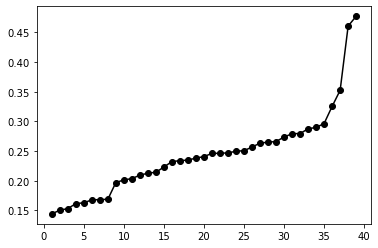

In [46]:
print(np.quantile(res.tolist(), [0,0.25,0.5,0.75,1]))
plt.plot(range(1, len(res)+1), sorted(res.tolist()), '-ok')

In [47]:
# df of DMSO vs treatment for each condition
d = pd.DataFrame(data=r.values(), index=r.keys(), columns=['ERCC pseudo-counts','var'])
d['Experiments'] = d.index
d

,ERCC pseudo-counts,var,Experiments
MV411-MYB-dTAG-DMSO_1h,0.160046,0.008426,MV411-MYB-dTAG-DMSO_1h
MV411-MYB-dTAG-VHL_1h,0.156083,0.008528,MV411-MYB-dTAG-VHL_1h
MONOMAC1-MYB-dTAG-DMSO_1h,0.243679,0.023537,MONOMAC1-MYB-dTAG-DMSO_1h
MONOMAC1-MYB-dTAG-VHL_1h,0.248195,0.011546,MONOMAC1-MYB-dTAG-VHL_1h
NOMO1-MYB-dTAG-DMSO_1h,0.210141,0.008563,NOMO1-MYB-dTAG-DMSO_1h
NOMO1-MYB-dTAG-VHL_1h,0.203728,0.026155,NOMO1-MYB-dTAG-VHL_1h
P31FUJ-MYB-dTAG-DMSO_1h,0.246260,0.012467,P31FUJ-MYB-dTAG-DMSO_1h
P31FUJ-MYB-dTAG-VHL_1h,0.339017,0.072594,P31FUJ-MYB-dTAG-VHL_1h
THP1-MYB-dTAG-DMSO_1h,0.270268,0.014301,THP1-MYB-dTAG-DMSO_1h
THP1-MYB-dTAG-VHL_1h,0.344050,0.084213,THP1-MYB-dTAG-VHL_1h


ERCC scaling factors (measures ERCC counts)
* treatment vs DMSO should be different
* &uarr; ERCC factor = &darr; transcripts
* protein level in treatment < DMSO: more ERCC transcripts in treatment than DMSO (less RNA transcripts)
* scaling factors: treatment > DMSO - ERCC counts/scaling factors in treatment should be higher
* scaling factor of control conditions should be similar

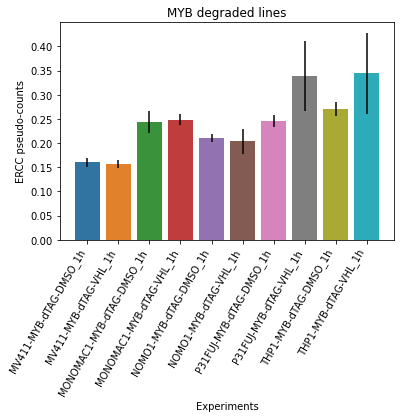

Saved to ../results/slamseq_MYB_degraded_lines_v1/plots/MYB_degraded_lines_v1_scaling_fact_with_conf.pdf


In [48]:
version = project.replace("_", " ").split(" ")[-1]
createDir(res_dir+"/plots/")

# barplot of DMSO vs VHL for each condition
sns.barplot(x="Experiments", y="ERCC pseudo-counts", data=d, ci=None, )
plt.errorbar(x=range(0,len(d)), y=d['ERCC pseudo-counts'],
             yerr=d['var'], fmt='none', ecolor="black")
plt.xticks(rotation=60, ha='right')
plt.title(project.replace("_", " ").split(" v")[0])

plt.savefig(res_dir+"plots/"+project+"_scaling_fact_with_conf.pdf", bbox_inches="tight")
plt.show()
print("Saved to "+res_dir+"plots/"+project+"_scaling_fact_with_conf.pdf")

__save average ERCC scaling factors__

In [60]:
d

,ERCC pseudo-counts,var,Experiments
MV411-MYB-dTAG-DMSO_1h,0.160046,0.008426,MV411-MYB-dTAG-DMSO_1h
MV411-MYB-dTAG-VHL_1h,0.156083,0.008528,MV411-MYB-dTAG-VHL_1h
MONOMAC1-MYB-dTAG-DMSO_1h,0.243679,0.023537,MONOMAC1-MYB-dTAG-DMSO_1h
MONOMAC1-MYB-dTAG-VHL_1h,0.248195,0.011546,MONOMAC1-MYB-dTAG-VHL_1h
NOMO1-MYB-dTAG-DMSO_1h,0.210141,0.008563,NOMO1-MYB-dTAG-DMSO_1h
NOMO1-MYB-dTAG-VHL_1h,0.203728,0.026155,NOMO1-MYB-dTAG-VHL_1h
P31FUJ-MYB-dTAG-DMSO_1h,0.246260,0.012467,P31FUJ-MYB-dTAG-DMSO_1h
P31FUJ-MYB-dTAG-VHL_1h,0.339017,0.072594,P31FUJ-MYB-dTAG-VHL_1h
THP1-MYB-dTAG-DMSO_1h,0.270268,0.014301,THP1-MYB-dTAG-DMSO_1h
THP1-MYB-dTAG-VHL_1h,0.344050,0.084213,THP1-MYB-dTAG-VHL_1h


In [62]:
# save avg ERCC pseudocounts
res_dir = "../results/slamseq_"+project+"/"
d.to_csv(res_dir+project+"_scaling_factors_avg.csv", header=True, index=True)

## save data to bucket

In [63]:
project

'MYB_degraded_lines_v1'

In [64]:
! gsutil -m cp ../../data/slamseq_$project/res/filter/* gs://amlproject/RNA/slamseq/$project/res/filter/ 
! gsutil -m cp ../../data/slamseq_$project/res/snp/* gs://amlproject/RNA/slamseq/$project/res/snp/ 
! gsutil -m cp ../../data/slamseq_$project/res/count/* gs://amlproject/RNA/slamseq/$project/res/count/

Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/ERCC_mr537-MV411-MYB-dTAG-VHL_1h-r2_filtered.bam.bed [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/ERCC_mr532-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam.bed [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/ERCC_mr538-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/ERCC_mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/ERCC_mr532-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/ERCC_mr538-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam.bed [Content-Type=application/octet-stream]...
Copying file://../../data/sl

Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr538-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr538-MV411-MYB-dTAG-VHL_1h-r3_filtered.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_filtered.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/filter/mr540-MONOMAC1-MYB-dTAG-DMSO_1h-r2_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines

Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/snp/mr546-MONOMAC1-MYB-dTAG-VHL_1h-r4_snp.vcf [Content-Type=text/vcard]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/snp/mr548-NOMO1-MYB-dTAG-DMSO_1h-r2_snp.vcf [Content-Type=text/vcard]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/snp/mr541-MONOMAC1-MYB-dTAG-DMSO_1h-r3_snp.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/snp/mr545-MONOMAC1-MYB-dTAG-VHL_1h-r3_snp.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/snp/mr548-NOMO1-MYB-dTAG-DMSO_1h-r2_snp.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/snp/mr550-NOMO1-MYB-dTAG-DMSO_1h-r4_snp.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/snp/mr547-NOMO1-MYB-dTAG-DMSO_1h-r1_snp.log [Content-Type=application/octet-str

Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr538-MV411-MYB-dTAG-VHL_1h-r3_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr542-MONOMAC1-MYB-dTAG-DMSO_1h-r4_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr542-MONOMAC1-MYB-dTAG-DMSO_1h-r4_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr542-MONOMAC1-MYB-dTAG-DMSO_1h-r4_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr542-MONOMAC1-MYB-dTAG-DMSO_1h-r4_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/slamseq

Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr554-NOMO1-MYB-dTAG-VHL_1h-r4_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr554-NOMO1-MYB-dTAG-VHL_1h-r4_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr555-P31FUJ-MYB-dTAG-DMSO_1h-r1_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr555-P31FUJ-MYB-dTAG-DMSO_1h-r1_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr555-P31FUJ-MYB-dTAG-DMSO_1h-r1_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_lines_v1/res/count/mr555-P31FUJ-MYB-dTAG-DMSO_1h-r1_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/slamseq_MYB_degraded_lines_v

# SLAM-seq
All SLAM-seq assays were performed at 60-70% confluency for adherent cells or
60% of the maximum cell density counted on a hemocytometer for suspension cells. 5-7h
prior to each assay, growth medium was aspirated and replaced. Unless stated otherwise,
cells were pre-treated with indicated small molecule inhibitors or 100µM IAA for 30 min
to pre-establish full target inhibition or degradation. Newly synthesized RNA was labeled
for indicated time spans (45 min or 60 min) at a final concentration of 100µM 4-
thiouridine (4sU, Carbosynth). Adherent cells were harvested by direct snap-freezing of
plates on dry ice. Suspension cells were spun down and immediately snap-frozen. RNA
extraction was performed using the RNeasy Plus Mini Kit (Qiagen). 

Total RNA was subjected to alkylation by iodoacetamide (Sigma, 10mM) for 15 min and RNA was repurified by ethanol precipitation. 500ng alkylated RNA were used as input for generating
3’-end mRNA sequencing libraries using a commercially available kit (QuantSeq 3′
mRNA-Seq Library Prep Kit FWD for Illumina and PCR Add-on Kit for Illumina,
Lexogen). Deep sequencing was performed using HiSeq1500 and HiSeq2500 platforms
(Illumina).

## make count files

In [65]:
project = project
res_folder = "res"
location = "../../data/slamseq_"+project+"/"+res_folder+"/"+"count/"
print(location)

../../data/slamseq_MYB_degraded_lines_v1/res/count/


In [66]:
# remove genes that have very low counts
mincount_toremove=5

# remove genes that have a variance of 0 across all samples (these we really want to remove)
# genes that have values of 0,1,2 everywhere
minvar_toremove=0

In [67]:
%%time

# all genes (not just protein coding)
readcounts, tccounts = rna.readFromSlamdunk(loc=location, 
                                            minvar_toremove=minvar_toremove, 
                                            mincount_toremove=mincount_toremove,
                                            verbose=False)

found 39 files:dict_keys(['mr532-MV411-MYB-dTAG-DMSO_1h-r1_tcount', 'mr533-MV411-MYB-dTAG-DMSO_1h-r2_tcount', 'mr534-MV411-MYB-dTAG-DMSO_1h-r3_tcount', 'mr535-MV411-MYB-dTAG-DMSO_1h-r4_tcount', 'mr536-MV411-MYB-dTAG-VHL_1h-r1_tcount', 'mr537-MV411-MYB-dTAG-VHL_1h-r2_tcount', 'mr538-MV411-MYB-dTAG-VHL_1h-r3_tcount', 'mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_tcount', 'mr540-MONOMAC1-MYB-dTAG-DMSO_1h-r2_tcount', 'mr541-MONOMAC1-MYB-dTAG-DMSO_1h-r3_tcount', 'mr542-MONOMAC1-MYB-dTAG-DMSO_1h-r4_tcount', 'mr543-MONOMAC1-MYB-dTAG-VHL_1h-r1_tcount', 'mr544-MONOMAC1-MYB-dTAG-VHL_1h-r2_tcount', 'mr545-MONOMAC1-MYB-dTAG-VHL_1h-r3_tcount', 'mr546-MONOMAC1-MYB-dTAG-VHL_1h-r4_tcount', 'mr547-NOMO1-MYB-dTAG-DMSO_1h-r1_tcount', 'mr548-NOMO1-MYB-dTAG-DMSO_1h-r2_tcount', 'mr549-NOMO1-MYB-dTAG-DMSO_1h-r3_tcount', 'mr550-NOMO1-MYB-dTAG-DMSO_1h-r4_tcount', 'mr551-NOMO1-MYB-dTAG-VHL_1h-r1_tcount', 'mr552-NOMO1-MYB-dTAG-VHL_1h-r2_tcount', 'mr553-NOMO1-MYB-dTAG-VHL_1h-r3_tcount', 'mr554-NOMO1-MYB-dTAG-VHL_1h-r4_tcou

check for duplicate gene rows

In [68]:
def dedup_df_genes(df):
    ''' sum rows with the same gene index and remove duplicate '''
    if df.shape[0] != len(df.index.drop_duplicates()):
        print("Duplicate gene rows!")
        print("{} rows | {} unique genes".format(df.shape[0], len(df.index.drop_duplicates())))
        print("Summing of duplicate gene rows.")
        
    # sum duplicate rows, same row order
    duplicate_genes = df.index[df.index.duplicated()].tolist()
    df = df.groupby(df.index).sum().loc[df.index.drop_duplicates()]
    if df.shape[0] != len(df.index.drop_duplicates()):
        raise ValueError(
            "Cannot collapse duplicate gene rows."
        )
    
    return df, duplicate_genes

In [69]:
readcounts, duplicate_genes = dedup_df_genes(readcounts)
tccounts, duplicate_genes = dedup_df_genes(tccounts)

if readcounts.shape != tccounts.shape:
    raise ValueError("readcounts and tccounts not the same dimensions: {} | {}".format(readcounts.shape, tccounts.shape))

Duplicate gene rows!
18675 rows | 18633 unique genes
Summing of duplicate gene rows.
Duplicate gene rows!
18675 rows | 18633 unique genes
Summing of duplicate gene rows.


## make density plot

In [70]:
res_dir = "../results/slamseq_{}/".format(project)
print(res_dir)
createDir(res_dir)

../results/slamseq_MYB_degraded_lines_v1/


In [71]:
# sort cols
col = tccounts.columns.tolist()
col.sort()
tccounts = tccounts[col]

In [72]:
# sort cols
col = readcounts.columns.tolist()
col.sort()
readcounts = readcounts[col]

In [73]:
print(readcounts.shape)
readcounts.iloc[:2]

(18633, 39)


,mr532-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr533-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr534-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr535-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr536-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr537-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr538-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_tcount,mr540-MONOMAC1-MYB-dTAG-DMSO_1h-r2_tcount,mr541-MONOMAC1-MYB-dTAG-DMSO_1h-r3_tcount,...,mr561-P31FUJ-MYB-dTAG-VHL_1h-r3_tcount,mr562-P31FUJ-MYB-dTAG-VHL_1h-r4_tcount,mr563-THP1-MYB-dTAG-DMSO_1h-r1_tcount,mr564-THP1-MYB-dTAG-DMSO_1h-r2_tcount,mr565-THP1-MYB-dTAG-DMSO_1h-r3_tcount,mr566-THP1-MYB-dTAG-DMSO_1h-r4_tcount,mr567-THP1-MYB-dTAG-VHL_1h-r1_tcount,mr568-THP1-MYB-dTAG-VHL_1h-r2_tcount,mr569-THP1-MYB-dTAG-VHL_1h-r3_tcount,mr570-THP1-MYB-dTAG-VHL_1h-r4_tcount
A1BG,2,0,1,4,0,5,0,25,18,33,...,39,22,17,17,31,29,20,20,48,27
A2M,0,1,0,0,0,0,0,3,1,3,...,0,0,11,21,19,5,8,13,19,11


read counts that are t $\rightarrow$ c converted (actively transcribed)
* most at 0 = most are not transcribed
* a lot at 1 or everything at 0 is weird

18044


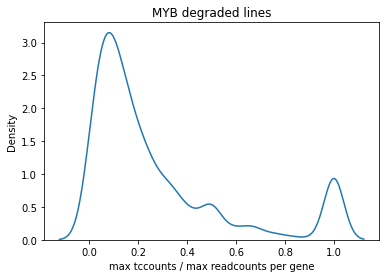

In [74]:
# what is the average of highly transcribed genes?
# tccounts/readcounts where sum of readcounts in all samples > 30 
a = tccounts[readcounts.sum(1)>30] / readcounts[readcounts.sum(1)>30]
a = a.fillna(0)
a = a.max(1).tolist() # max val per gene
a.sort()
print(len(a))
sns.kdeplot(a)
plt.xlabel("max tccounts / max readcounts per gene")
plt.title(project.replace("_", " ").split(" v")[0])

plt.savefig(res_dir+'plots/'+project+'_tccounts_readcounts_density.pdf', dpi=300, bbox_inches="tight")
plt.show()

In [75]:
# median or average across replicates t -> c converted
np.median(a)

0.1595803914026942

In [76]:
# Save counts to csv
counts_file_prefix = project+'_'+str(minvar_toremove)+'_'+str(mincount_toremove)

readcounts.to_csv(res_dir+counts_file_prefix+"_readcounts.csv",index=True, index_label="GENE")
print("Saved readcounts to: {}".format(res_dir+counts_file_prefix+"_readcounts.csv"))

tccounts.to_csv(res_dir+counts_file_prefix+"_tccounts.csv",index=True, index_label="GENE")
print("Saved tccounts to: {}".format(res_dir+counts_file_prefix+"_tccounts.csv"))

Saved readcounts to: ../results/slamseq_MYB_degraded_lines_v1/MYB_degraded_lines_v1_0_5_readcounts.csv
Saved tccounts to: ../results/slamseq_MYB_degraded_lines_v1/MYB_degraded_lines_v1_0_5_tccounts.csv


## make more dfs (mead, median, etc.)

In [77]:
readcounts.iloc[:1]

,mr532-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr533-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr534-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr535-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr536-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr537-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr538-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_tcount,mr540-MONOMAC1-MYB-dTAG-DMSO_1h-r2_tcount,mr541-MONOMAC1-MYB-dTAG-DMSO_1h-r3_tcount,...,mr561-P31FUJ-MYB-dTAG-VHL_1h-r3_tcount,mr562-P31FUJ-MYB-dTAG-VHL_1h-r4_tcount,mr563-THP1-MYB-dTAG-DMSO_1h-r1_tcount,mr564-THP1-MYB-dTAG-DMSO_1h-r2_tcount,mr565-THP1-MYB-dTAG-DMSO_1h-r3_tcount,mr566-THP1-MYB-dTAG-DMSO_1h-r4_tcount,mr567-THP1-MYB-dTAG-VHL_1h-r1_tcount,mr568-THP1-MYB-dTAG-VHL_1h-r2_tcount,mr569-THP1-MYB-dTAG-VHL_1h-r3_tcount,mr570-THP1-MYB-dTAG-VHL_1h-r4_tcount
A1BG,2,0,1,4,0,5,0,25,18,33,...,39,22,17,17,31,29,20,20,48,27


In [78]:
print("Genes with highest read counts per sample.")
for column in readcounts:
    print(column.split("-", 1)[1].split("_")[0] +": "+ str(readcounts[column].idxmax()) 
          +" ("+str(readcounts[column].max())+")")

Genes with highest read counts per sample.
MV411-MYB-dTAG-DMSO: ACTG1 (108739)
MV411-MYB-dTAG-DMSO: ACTG1 (141681)
MV411-MYB-dTAG-DMSO: ACTG1 (128575)
MV411-MYB-dTAG-DMSO: ACTG1 (107317)
MV411-MYB-dTAG-VHL: ACTG1 (100662)
MV411-MYB-dTAG-VHL: ACTG1 (149918)
MV411-MYB-dTAG-VHL: ACTG1 (122586)
MONOMAC1-MYB-dTAG-DMSO: LYZ (249747)
MONOMAC1-MYB-dTAG-DMSO: LYZ (210424)
MONOMAC1-MYB-dTAG-DMSO: LYZ (293851)
MONOMAC1-MYB-dTAG-DMSO: LYZ (219143)
MONOMAC1-MYB-dTAG-VHL: LYZ (215159)
MONOMAC1-MYB-dTAG-VHL: LYZ (227737)
MONOMAC1-MYB-dTAG-VHL: LYZ (154142)
MONOMAC1-MYB-dTAG-VHL: LYZ (231904)
NOMO1-MYB-dTAG-DMSO: LYZ (214632)
NOMO1-MYB-dTAG-DMSO: LYZ (310085)
NOMO1-MYB-dTAG-DMSO: LYZ (242828)
NOMO1-MYB-dTAG-DMSO: LYZ (438384)
NOMO1-MYB-dTAG-VHL: LYZ (220100)
NOMO1-MYB-dTAG-VHL: LYZ (195808)
NOMO1-MYB-dTAG-VHL: LYZ (324023)
NOMO1-MYB-dTAG-VHL: LYZ (234919)
P31FUJ-MYB-dTAG-DMSO: LCP1 (83817)
P31FUJ-MYB-dTAG-DMSO: SRGN (122857)
P31FUJ-MYB-dTAG-DMSO: LCP1 (87891)
P31FUJ-MYB-dTAG-DMSO: LCP1 (93990)
P31FUJ-

In [79]:
print(set([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns]))
print(tccounts.columns[0].split('-', 1)[-1].rpartition("-")[0])
list(dict.fromkeys([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns]))

{'NOMO1-MYB-dTAG-VHL_1h', 'THP1-MYB-dTAG-DMSO_1h', 'MV411-MYB-dTAG-VHL_1h', 'MONOMAC1-MYB-dTAG-VHL_1h', 'P31FUJ-MYB-dTAG-DMSO_1h', 'MV411-MYB-dTAG-DMSO_1h', 'P31FUJ-MYB-dTAG-VHL_1h', 'THP1-MYB-dTAG-VHL_1h', 'NOMO1-MYB-dTAG-DMSO_1h', 'MONOMAC1-MYB-dTAG-DMSO_1h'}
MV411-MYB-dTAG-DMSO_1h


['MV411-MYB-dTAG-DMSO_1h',
 'MV411-MYB-dTAG-VHL_1h',
 'MONOMAC1-MYB-dTAG-DMSO_1h',
 'MONOMAC1-MYB-dTAG-VHL_1h',
 'NOMO1-MYB-dTAG-DMSO_1h',
 'NOMO1-MYB-dTAG-VHL_1h',
 'P31FUJ-MYB-dTAG-DMSO_1h',
 'P31FUJ-MYB-dTAG-VHL_1h',
 'THP1-MYB-dTAG-DMSO_1h',
 'THP1-MYB-dTAG-VHL_1h']

In [80]:
# get mean counts per condition
mtccounts = pd.DataFrame()
mreadcounts = pd.DataFrame()
# conditions maintaing column order
for i in list(dict.fromkeys([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns])):
    print(i)
    mtccounts[i] = tccounts[[v for v in tccounts.columns if i in v]].mean(1)
    mreadcounts[i] = readcounts[[v for v in readcounts.columns if i in v]].mean(1)

# save mean counts files
mtccounts.to_csv(res_dir+counts_file_prefix+"_mean_tccounts.csv", index=True, index_label="GENE")
mreadcounts.to_csv(res_dir+counts_file_prefix+"_mean_readcounts.csv", index=True, index_label="GENE")

MV411-MYB-dTAG-DMSO_1h
MV411-MYB-dTAG-VHL_1h
MONOMAC1-MYB-dTAG-DMSO_1h
MONOMAC1-MYB-dTAG-VHL_1h
NOMO1-MYB-dTAG-DMSO_1h
NOMO1-MYB-dTAG-VHL_1h
P31FUJ-MYB-dTAG-DMSO_1h
P31FUJ-MYB-dTAG-VHL_1h
THP1-MYB-dTAG-DMSO_1h
THP1-MYB-dTAG-VHL_1h


In [81]:
# get median counts per condition
mtccounts = pd.DataFrame()
mreadcounts = pd.DataFrame()
# conditions maintaing column order
for i in list(dict.fromkeys([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns])):
    print(i)
    mtccounts[i] = tccounts[[v for v in tccounts.columns if i in v]].median(1)
    mreadcounts[i] = readcounts[[v for v in readcounts.columns if i in v]].median(1)

# save median counts files
mtccounts.to_csv(res_dir+counts_file_prefix+"_median_tccounts.csv", index=True, index_label="GENE")
mreadcounts.to_csv(res_dir+counts_file_prefix+"_median_readcounts.csv", index=True, index_label="GENE")

MV411-MYB-dTAG-DMSO_1h
MV411-MYB-dTAG-VHL_1h
MONOMAC1-MYB-dTAG-DMSO_1h
MONOMAC1-MYB-dTAG-VHL_1h
NOMO1-MYB-dTAG-DMSO_1h
NOMO1-MYB-dTAG-VHL_1h
P31FUJ-MYB-dTAG-DMSO_1h
P31FUJ-MYB-dTAG-VHL_1h
THP1-MYB-dTAG-DMSO_1h
THP1-MYB-dTAG-VHL_1h


In [82]:
(tccounts/readcounts).fillna(0).iloc[:2]

,mr532-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr533-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr534-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr535-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr536-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr537-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr538-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_tcount,mr540-MONOMAC1-MYB-dTAG-DMSO_1h-r2_tcount,mr541-MONOMAC1-MYB-dTAG-DMSO_1h-r3_tcount,...,mr561-P31FUJ-MYB-dTAG-VHL_1h-r3_tcount,mr562-P31FUJ-MYB-dTAG-VHL_1h-r4_tcount,mr563-THP1-MYB-dTAG-DMSO_1h-r1_tcount,mr564-THP1-MYB-dTAG-DMSO_1h-r2_tcount,mr565-THP1-MYB-dTAG-DMSO_1h-r3_tcount,mr566-THP1-MYB-dTAG-DMSO_1h-r4_tcount,mr567-THP1-MYB-dTAG-VHL_1h-r1_tcount,mr568-THP1-MYB-dTAG-VHL_1h-r2_tcount,mr569-THP1-MYB-dTAG-VHL_1h-r3_tcount,mr570-THP1-MYB-dTAG-VHL_1h-r4_tcount
A1BG,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.04,0.0,0.060606,...,0.0,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0
A2M,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.052632,0.0


In [83]:
# Save tccounts/readcounts file
(tccounts/readcounts).fillna(0).to_csv(res_dir+counts_file_prefix+"_tccounts_per_readcounts.csv")
print("Saved tccounts/readcounts to: {}".format(res_dir+counts_file_prefix+"_tccounts_per_readcounts.csv"))

Saved tccounts/readcounts to: ../results/slamseq_MYB_degraded_lines_v1/MYB_degraded_lines_v1_0_5_tccounts_per_readcounts.csv


## look at similarity across replicates

In [84]:
# conditions
[i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns]

['MV411-MYB-dTAG-DMSO_1h',
 'MV411-MYB-dTAG-DMSO_1h',
 'MV411-MYB-dTAG-DMSO_1h',
 'MV411-MYB-dTAG-DMSO_1h',
 'MV411-MYB-dTAG-VHL_1h',
 'MV411-MYB-dTAG-VHL_1h',
 'MV411-MYB-dTAG-VHL_1h',
 'MONOMAC1-MYB-dTAG-DMSO_1h',
 'MONOMAC1-MYB-dTAG-DMSO_1h',
 'MONOMAC1-MYB-dTAG-DMSO_1h',
 'MONOMAC1-MYB-dTAG-DMSO_1h',
 'MONOMAC1-MYB-dTAG-VHL_1h',
 'MONOMAC1-MYB-dTAG-VHL_1h',
 'MONOMAC1-MYB-dTAG-VHL_1h',
 'MONOMAC1-MYB-dTAG-VHL_1h',
 'NOMO1-MYB-dTAG-DMSO_1h',
 'NOMO1-MYB-dTAG-DMSO_1h',
 'NOMO1-MYB-dTAG-DMSO_1h',
 'NOMO1-MYB-dTAG-DMSO_1h',
 'NOMO1-MYB-dTAG-VHL_1h',
 'NOMO1-MYB-dTAG-VHL_1h',
 'NOMO1-MYB-dTAG-VHL_1h',
 'NOMO1-MYB-dTAG-VHL_1h',
 'P31FUJ-MYB-dTAG-DMSO_1h',
 'P31FUJ-MYB-dTAG-DMSO_1h',
 'P31FUJ-MYB-dTAG-DMSO_1h',
 'P31FUJ-MYB-dTAG-DMSO_1h',
 'P31FUJ-MYB-dTAG-VHL_1h',
 'P31FUJ-MYB-dTAG-VHL_1h',
 'P31FUJ-MYB-dTAG-VHL_1h',
 'P31FUJ-MYB-dTAG-VHL_1h',
 'THP1-MYB-dTAG-DMSO_1h',
 'THP1-MYB-dTAG-DMSO_1h',
 'THP1-MYB-dTAG-DMSO_1h',
 'THP1-MYB-dTAG-DMSO_1h',
 'THP1-MYB-dTAG-VHL_1h',
 'THP1-MYB-dTAG-V

Replicate similarity plot saved to: ../results/slamseq_MYB_degraded_lines_v1/plots/MYB_degraded_lines_v1_similarity_replicates_sorted_tccounts.pdf


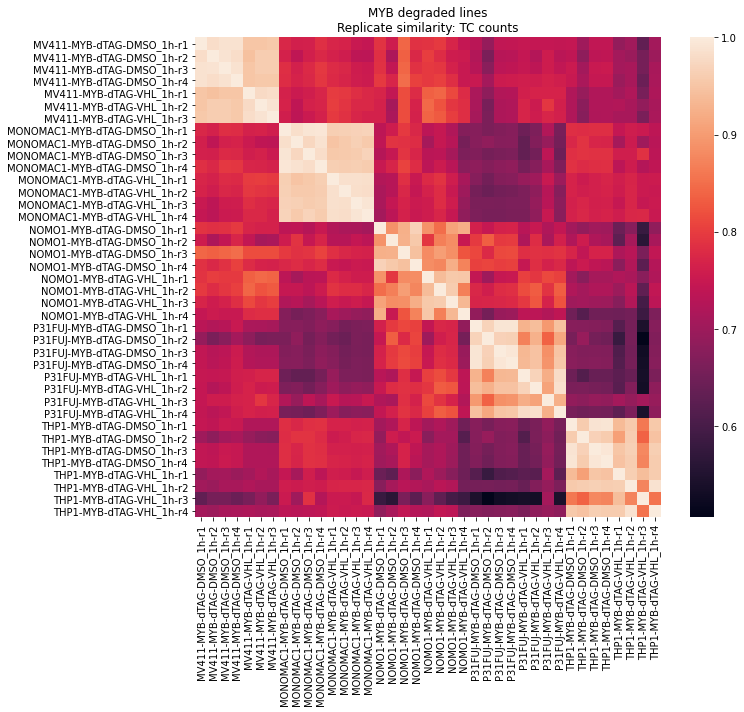

In [92]:
%matplotlib inline
import matplotlib.font_manager

font_settings = {
    "family" : "sans-serif",
    "size" : 10
}
plt.rc("font", **font_settings)

# tccounts
fig, ax = plt.subplots(figsize=(11,10))
sns.heatmap(tccounts.corr(),
            # condition w/ rep label
            xticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns],
            yticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns],
            ax=ax, cmap="rocket")#, vmin=0.9, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: TC counts")
plt.tight_layout()

plt.savefig(res_dir+'plots/'+project+'_similarity_replicates_sorted_tccounts.pdf', dpi=300)

print("Replicate similarity plot saved to: {}".format(res_dir+'plots/'+project+
                                                      '_similarity_replicates_sorted_tccounts.pdf'))

Replicate similarity plot saved to: ../results/slamseq_MYB_degraded_lines_v1/plots/MYB_degraded_lines_v1_similarity_replicates_sorted_readcounts.pdf


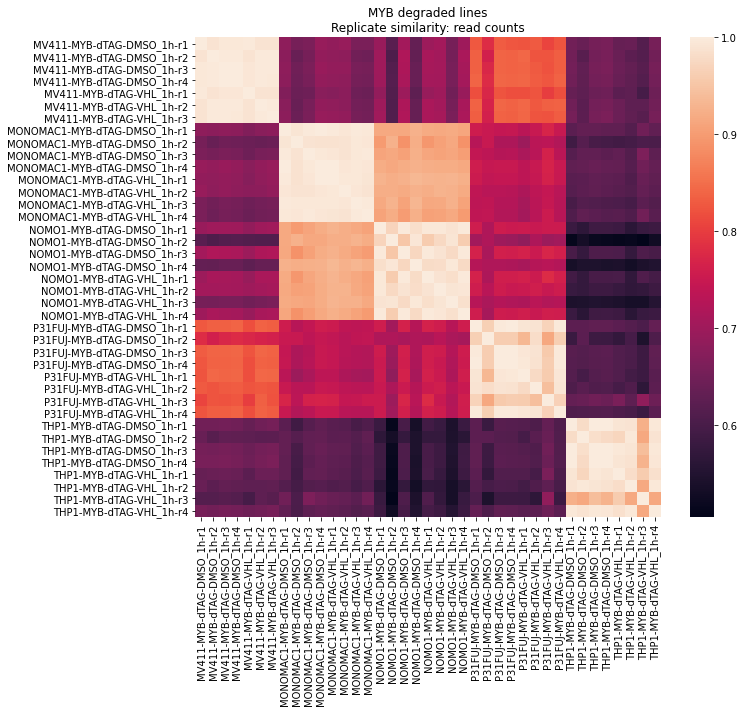

In [94]:
%matplotlib inline

# readcounts
fig, ax = plt.subplots(figsize=(11,10))
sns.heatmap(readcounts.corr(), 
            # condition w/ rep label
            xticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns],
            yticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns],
            ax=ax) #, vmin=0.985, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: read counts")
plt.tight_layout()

plt.savefig(res_dir+'plots/'+project+'_similarity_replicates_sorted_readcounts.pdf', dpi=300)

print("Replicate similarity plot saved to: {}".format(res_dir+'plots/'+project+
                                                      '_similarity_replicates_sorted_readcounts.pdf'))

# DESEQ Analaysis

In [95]:
res_dir = "../results/slamseq_{}/".format(project)
print(res_dir)

../results/slamseq_MYB_degraded_lines_v1/


In [97]:
# make genes col
readcounts["genes"] = readcounts.index
readcounts = readcounts.reset_index(drop=True)

tccounts["genes"] = tccounts.index
tccounts = tccounts.reset_index(drop=True)

__include all replicates__

__ERCC normalization__
* MV411-MYB-dTAG - no
* MONOMAC1-MYB-dTAG - no
* NOMO1-MYB-dTAG - no
* P31FUJ - yes
* THP1-MYB-dTAG - no

In [99]:
drop_samples = []

In [101]:
# col info
cols = tccounts.columns[:-1]
experiments = [x.rsplit("-", 2)[0].split("-", 1)[-1] for x in cols]
conds = [x.split("-", 1)[1].rsplit("-", 1)[0] for x in cols]
time = [x.split("_")[-1] for x in conds]
treatment = [x.split("-")[-1].split("_")[0] for x in conds]
rep = [x.split("_")[-2].split("-")[-1] for x in cols]
drop = [True if any(sample in x for sample in drop_samples) else False for x in cols]

# experimental design
exp_design = pd.DataFrame(list(zip(cols, experiments, conds, time, treatment, rep, drop)), 
                          columns=["col", "experiment", "cond", "time", "treatment", "rep", "drop"])

exp_design

,col,experiment,cond,time,treatment,rep,drop
0,mr532-MV411-MYB-dTAG-DMSO_1h-r1_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-DMSO_1h,1h,DMSO,r1,False
1,mr533-MV411-MYB-dTAG-DMSO_1h-r2_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-DMSO_1h,1h,DMSO,r2,False
2,mr534-MV411-MYB-dTAG-DMSO_1h-r3_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-DMSO_1h,1h,DMSO,r3,False
3,mr535-MV411-MYB-dTAG-DMSO_1h-r4_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-DMSO_1h,1h,DMSO,r4,False
4,mr536-MV411-MYB-dTAG-VHL_1h-r1_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-VHL_1h,1h,VHL,r1,False
5,mr537-MV411-MYB-dTAG-VHL_1h-r2_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-VHL_1h,1h,VHL,r2,False
6,mr538-MV411-MYB-dTAG-VHL_1h-r3_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-VHL_1h,1h,VHL,r3,False
7,mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_tcount,MONOMAC1-MYB-dTAG,MONOMAC1-MYB-dTAG-DMSO_1h,1h,DMSO,r1,False
8,mr540-MONOMAC1-MYB-dTAG-DMSO_1h-r2_tcount,MONOMAC1-MYB-dTAG,MONOMAC1-MYB-dTAG-DMSO_1h,1h,DMSO,r2,False
9,mr541-MONOMAC1-MYB-dTAG-DMSO_1h-r3_tcount,MONOMAC1-MYB-dTAG,MONOMAC1-MYB-dTAG-DMSO_1h,1h,DMSO,r3,False


In [102]:
# save experimental design / metaData
exp_design.to_csv(res_dir+project+"_metaData.csv", index=False)
print("Save exp design/meta data to: "+res_dir+project+"_metaData.csv")

Save exp design/meta data to: ../results/slamseq_MYB_degraded_lines_v1/MYB_degraded_lines_v1_metaData.csv


## MV411-MYB-dTAG

### make design matrix

In [ ]:
# MV411-MYB-dTAG 1h
version = "v1"
var_name = "experiment"
var = "MV411-MYB-dTAG"
var1 = "DMSO"
var2 = "VHL"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [ ]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [ ]:
# get just var data
# remove dropped reps
var_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["drop"] == False)
            else 0 for idx in range(exp_design.shape[0])]

var1_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var1) and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

var2_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var2) and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

In [ ]:
# all columns
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=[var1, var2], 
                      data=np.array([var1_cols, var2_cols], dtype=bool).T)

In [ ]:
design

In [ ]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [111]:
scaling="ERCCsamplewise"

__make DESeq object__

In [112]:
# tccounts DESeq gene object
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [113]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate & modify size factors__

In [114]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [115]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr532-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam    0.152942
ERCC_mr533-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam    0.168036
ERCC_mr534-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam    0.168804
ERCC_mr535-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam    0.150402
ERCC_mr536-MV411-MYB-dTAG-VHL_1h-r1_filtered.bam     0.162733
ERCC_mr537-MV411-MYB-dTAG-VHL_1h-r2_filtered.bam     0.161470
ERCC_mr538-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam     0.144045
Name: 1, dtype: float64

__modify size factors__
<br> VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [116]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [117]:
res[[i for i in res.index if '-VHL' in i]].values

array([0.16273321, 0.16147008, 0.14404482])

In [118]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

__run it__

In [119]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.66 s, sys: 1.42 s, total: 9.08 s
Wall time: 6.66 s


In [120]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.04 s, sys: 1.08 s, total: 8.12 s
Wall time: 5.9 s


In [124]:
# MV411-MYB-dTAG 1h tccounts ERCC
resGene_tc

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.134766,-0.739417,3.816939,0.193720,0.846395,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
2,9.203222,0.577072,0.582592,-0.990524,0.321918,0.891407,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,NAT2,NAT2
4,19.286811,-0.144245,0.449578,0.320844,0.748329,0.969156,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,16.546201,0.217213,0.463157,-0.468984,0.639081,0.959883,106736475,106736475
18629,0.758069,0.244078,2.349701,-0.103876,0.917268,NaN,GET1-SH3BGR,GET1-SH3BGR
18630,6.811266,-0.841432,0.706126,1.191617,0.233411,0.841847,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,6.103635,-0.151937,0.770085,0.197299,0.843594,0.981941,107303344,107303344


In [125]:
# MV411-MYB-dTAG 1h readcounts ERCC
resGene_read

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,1.609345,-0.326844,1.632965,0.200154,0.841360,NaN,A1BG,A1BG
1,0.128633,-0.662316,3.816939,0.173520,0.862243,NaN,A2M,A2M
2,132.391510,0.169066,0.208175,-0.812135,0.416714,0.999925,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,NAT2,NAT2
4,1043.833806,-0.051864,0.119901,0.432559,0.665335,0.999925,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,75.663467,0.267736,0.247741,-1.080707,0.279827,0.999925,106736475,106736475
18629,20.863295,-0.621681,0.448055,1.387510,0.165286,0.999925,GET1-SH3BGR,GET1-SH3BGR
18630,402.385538,0.120411,0.139607,-0.862499,0.388413,0.999925,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,248.196611,0.174011,0.141110,-1.233154,0.217518,0.999925,107303344,107303344


__save DESeq results__

In [121]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [123]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))

'MYB_degraded_lines_v1_MV411-MYB-dTAG_ERCCsamplewise_0_5_deseq_tccounts.csv'

In [126]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_MV411-MYB-dTAG_ERCCsamplewise_0_5_deseq_tccounts.csv


In [127]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_MV411-MYB-dTAG_ERCCsamplewise_0_5_deseq_readcounts.csv


### Unscaled

In [128]:
scaling = None

__make DESEq object__

In [129]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [130]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate size factors__

In [131]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

__run it__

In [132]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.52 s, sys: 1.27 s, total: 7.79 s
Wall time: 5.21 s


In [133]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.04 s, sys: 1.14 s, total: 8.18 s
Wall time: 5.69 s


In [134]:
# MV411-MYB-dTAG 1h tccounts unscaled
resGene_tc

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.134766,-0.777803,3.816939,0.203777,0.838528,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
2,9.044708,0.534291,0.581199,-0.919292,0.357943,0.894033,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,NAT2,NAT2
4,19.153268,-0.172056,0.451000,0.381498,0.702834,0.963507,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,16.289794,0.174189,0.460487,-0.378271,0.705230,0.964819,106736475,106736475
18629,0.761190,0.243671,2.337422,-0.104248,0.916973,NaN,GET1-SH3BGR,GET1-SH3BGR
18630,6.745435,-0.882523,0.704594,1.252526,0.210378,0.800346,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,6.083396,-0.173004,0.770445,0.224551,0.822329,0.977412,107303344,107303344


In [135]:
# MV411-MYB-dTAG 1h readcounts unscaled
resGene_read

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,1.614404,-0.331399,1.641151,0.201931,0.839971,NaN,A1BG,A1BG
1,0.128633,-0.700701,3.816939,0.183577,0.854345,NaN,A2M,A2M
2,130.705972,0.128996,0.205508,-0.627695,0.530203,0.999939,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,NAT2,NAT2
4,1030.634609,-0.094600,0.106010,0.892375,0.372192,0.999939,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,74.751285,0.230990,0.245126,-0.942333,0.346022,0.999939,106736475,106736475
18629,20.687032,-0.657661,0.442842,1.485092,0.137519,0.999939,GET1-SH3BGR,GET1-SH3BGR
18630,397.666020,0.083117,0.136601,-0.608469,0.542876,0.999939,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,245.299410,0.136355,0.132619,-1.028166,0.303872,0.999939,107303344,107303344


__save DESeq results__

In [136]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [137]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))

'MYB_degraded_lines_v1_MV411-MYB-dTAG_0_5_deseq_tccounts.csv'

In [138]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_MV411-MYB-dTAG_0_5_deseq_tccounts.csv


In [139]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_MV411-MYB-dTAG_0_5_deseq_readcounts.csv


## MONOMAC1-MYB-dTAG

### make design matrix

In [140]:
exp_design

,col,experiment,cond,time,treatment,rep,drop
0,mr532-MV411-MYB-dTAG-DMSO_1h-r1_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-DMSO_1h,1h,DMSO,r1,False
1,mr533-MV411-MYB-dTAG-DMSO_1h-r2_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-DMSO_1h,1h,DMSO,r2,False
2,mr534-MV411-MYB-dTAG-DMSO_1h-r3_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-DMSO_1h,1h,DMSO,r3,False
3,mr535-MV411-MYB-dTAG-DMSO_1h-r4_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-DMSO_1h,1h,DMSO,r4,False
4,mr536-MV411-MYB-dTAG-VHL_1h-r1_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-VHL_1h,1h,VHL,r1,False
5,mr537-MV411-MYB-dTAG-VHL_1h-r2_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-VHL_1h,1h,VHL,r2,False
6,mr538-MV411-MYB-dTAG-VHL_1h-r3_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-VHL_1h,1h,VHL,r3,False
7,mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_tcount,MONOMAC1-MYB-dTAG,MONOMAC1-MYB-dTAG-DMSO_1h,1h,DMSO,r1,False
8,mr540-MONOMAC1-MYB-dTAG-DMSO_1h-r2_tcount,MONOMAC1-MYB-dTAG,MONOMAC1-MYB-dTAG-DMSO_1h,1h,DMSO,r2,False
9,mr541-MONOMAC1-MYB-dTAG-DMSO_1h-r3_tcount,MONOMAC1-MYB-dTAG,MONOMAC1-MYB-dTAG-DMSO_1h,1h,DMSO,r3,False


In [157]:
# MONOMAC1-MYB-dTAG 1h
version = "v1"
var_name = "experiment"
var = "MONOMAC1-MYB-dTAG"
var1 = "DMSO"
var2 = "VHL"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [158]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [159]:
# get just var data
# remove dropped reps
var_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["drop"] == False)
            else 0 for idx in range(exp_design.shape[0])]

var1_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var1) and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

var2_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var2) and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

In [160]:
# all columns
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=[var1, var2], 
                      data=np.array([var1_cols, var2_cols], dtype=bool).T)

In [161]:
design

,DMSO,VHL
mr532.MV411.MYB.dTAG.DMSO_1h.r1_tcount,False,False
mr533.MV411.MYB.dTAG.DMSO_1h.r2_tcount,False,False
mr534.MV411.MYB.dTAG.DMSO_1h.r3_tcount,False,False
mr535.MV411.MYB.dTAG.DMSO_1h.r4_tcount,False,False
mr536.MV411.MYB.dTAG.VHL_1h.r1_tcount,False,False
mr537.MV411.MYB.dTAG.VHL_1h.r2_tcount,False,False
mr538.MV411.MYB.dTAG.VHL_1h.r3_tcount,False,False
mr539.MONOMAC1.MYB.dTAG.DMSO_1h.r1_tcount,True,False
mr540.MONOMAC1.MYB.dTAG.DMSO_1h.r2_tcount,True,False
mr541.MONOMAC1.MYB.dTAG.DMSO_1h.r3_tcount,True,False


In [162]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [163]:
scaling="ERCCsamplewise"

__make DESeq object__

In [164]:
# tccounts DESeq gene object
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [165]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate & modify size factors__

In [166]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [167]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_filtered.bam    0.246249
ERCC_mr540-MONOMAC1-MYB-dTAG-DMSO_1h-r2_filtered.bam    0.234859
ERCC_mr541-MONOMAC1-MYB-dTAG-DMSO_1h-r3_filtered.bam    0.279300
ERCC_mr542-MONOMAC1-MYB-dTAG-DMSO_1h-r4_filtered.bam    0.214309
ERCC_mr543-MONOMAC1-MYB-dTAG-VHL_1h-r1_filtered.bam     0.233750
ERCC_mr544-MONOMAC1-MYB-dTAG-VHL_1h-r2_filtered.bam     0.246051
ERCC_mr545-MONOMAC1-MYB-dTAG-VHL_1h-r3_filtered.bam     0.246942
ERCC_mr546-MONOMAC1-MYB-dTAG-VHL_1h-r4_filtered.bam     0.266039
Name: 1, dtype: float64

__modify size factors__
<br> VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [168]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [169]:
res[[i for i in res.index if '-VHL' in i]].values

array([0.23374983, 0.24605062, 0.24694174, 0.26603851])

In [170]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

__run it__

In [171]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 11.1 s, sys: 316 ms, total: 11.4 s
Wall time: 40 s


In [172]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 11.5 s, sys: 892 ms, total: 12.4 s
Wall time: 40.3 s


In [173]:
# MONOMAC1-MYB-dTAG 1h tccounts ERCC
resGene_tc

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,1.162663,1.371242,1.499568,-0.914425,0.360494,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
2,16.996367,-1.073309,0.409107,2.623540,0.008702,0.137525,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,NAT2,NAT2
4,12.469558,0.373320,0.468914,-0.796138,0.425952,0.892741,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,14.573697,-0.437288,0.452385,0.966628,0.333730,0.843437,106736475,106736475
18629,0.776372,1.174611,2.017399,-0.582240,0.560405,NaN,GET1-SH3BGR,GET1-SH3BGR
18630,2.718728,0.900732,1.082871,-0.831801,0.405522,NaN,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,10.035872,-0.150273,0.509806,0.294766,0.768173,0.977687,107303344,107303344


In [174]:
# MONOMAC1-MYB-dTAG 1h readcounts ERCC
resGene_read

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,18.525074,-0.472693,0.372763,1.268077,0.204771,0.999987,A1BG,A1BG
1,2.713500,0.280781,0.938170,-0.299286,0.764722,NaN,A2M,A2M
2,99.578917,-0.449477,0.196005,2.293191,0.021837,0.665193,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,NAT2,NAT2
4,552.213880,-0.050065,0.134057,0.373459,0.708807,0.999987,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,70.197795,-0.260839,0.243277,1.072191,0.283634,0.999987,106736475,106736475
18629,45.191407,-0.067643,0.260054,0.260112,0.794777,0.999987,GET1-SH3BGR,GET1-SH3BGR
18630,164.419356,0.094597,0.156423,-0.604754,0.545342,0.999987,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,133.029069,-0.046433,0.167435,0.277317,0.781537,0.999987,107303344,107303344


__save DESeq results__

In [175]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [176]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))

'MYB_degraded_lines_v1_MONOMAC1-MYB-dTAG_ERCCsamplewise_0_5_deseq_tccounts.csv'

In [177]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_MONOMAC1-MYB-dTAG_ERCCsamplewise_0_5_deseq_tccounts.csv


In [178]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_MONOMAC1-MYB-dTAG_ERCCsamplewise_0_5_deseq_readcounts.csv


### Unscaled

In [179]:
scaling = None

__make DESeq object__

In [180]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [181]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate size factors__

In [182]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

__run it__

In [183]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 10.2 s, sys: 276 ms, total: 10.5 s
Wall time: 37.5 s


In [184]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 12.5 s, sys: 804 ms, total: 13.3 s
Wall time: 44.5 s


In [185]:
# MONOMAC1-MYB-dTAG 1h tccounts unscaled
resGene_tc

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,1.163658,1.381458,1.491751,-0.926065,0.354412,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
2,17.052170,-1.048627,0.404834,2.590265,0.009590,0.122520,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,NAT2,NAT2
4,12.530161,0.390675,0.462639,-0.844450,0.398418,0.842156,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,14.775114,-0.392826,0.455174,0.863024,0.388125,0.834965,106736475,106736475
18629,0.766080,1.165367,2.023064,-0.576040,0.564588,NaN,GET1-SH3BGR,GET1-SH3BGR
18630,2.728711,0.913250,1.079705,-0.845833,0.397646,NaN,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,10.100497,-0.126178,0.505333,0.249692,0.802825,NaN,107303344,107303344


In [186]:
# MONOMAC1-MYB-dTAG 1h readcounts unscaled
resGene_read

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,18.589561,-0.454800,0.359322,1.265718,0.205614,0.999612,A1BG,A1BG
1,2.750372,0.311400,0.914880,-0.340373,0.733576,NaN,A2M,A2M
2,100.478991,-0.419197,0.198305,2.113906,0.034523,0.767652,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,NAT2,NAT2
4,555.665589,-0.031327,0.123132,0.254420,0.799171,0.999612,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,71.263648,-0.217913,0.260186,0.837529,0.402296,0.999612,106736475,106736475
18629,45.576249,-0.040778,0.256400,0.159040,0.873637,0.999612,GET1-SH3BGR,GET1-SH3BGR
18630,165.875831,0.119961,0.151422,-0.792230,0.428227,0.999612,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,133.839633,-0.027087,0.155132,0.174605,0.861390,0.999612,107303344,107303344


__save DESeq results__

In [187]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [188]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))

'MYB_degraded_lines_v1_MONOMAC1-MYB-dTAG_0_5_deseq_tccounts.csv'

In [189]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_MONOMAC1-MYB-dTAG_0_5_deseq_tccounts.csv


In [190]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_MONOMAC1-MYB-dTAG_0_5_deseq_readcounts.csv


## NOMO1-MYB-dTAG

### make design matrix

In [191]:
exp_design

,col,experiment,cond,time,treatment,rep,drop
0,mr532-MV411-MYB-dTAG-DMSO_1h-r1_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-DMSO_1h,1h,DMSO,r1,False
1,mr533-MV411-MYB-dTAG-DMSO_1h-r2_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-DMSO_1h,1h,DMSO,r2,False
2,mr534-MV411-MYB-dTAG-DMSO_1h-r3_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-DMSO_1h,1h,DMSO,r3,False
3,mr535-MV411-MYB-dTAG-DMSO_1h-r4_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-DMSO_1h,1h,DMSO,r4,False
4,mr536-MV411-MYB-dTAG-VHL_1h-r1_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-VHL_1h,1h,VHL,r1,False
5,mr537-MV411-MYB-dTAG-VHL_1h-r2_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-VHL_1h,1h,VHL,r2,False
6,mr538-MV411-MYB-dTAG-VHL_1h-r3_tcount,MV411-MYB-dTAG,MV411-MYB-dTAG-VHL_1h,1h,VHL,r3,False
7,mr539-MONOMAC1-MYB-dTAG-DMSO_1h-r1_tcount,MONOMAC1-MYB-dTAG,MONOMAC1-MYB-dTAG-DMSO_1h,1h,DMSO,r1,False
8,mr540-MONOMAC1-MYB-dTAG-DMSO_1h-r2_tcount,MONOMAC1-MYB-dTAG,MONOMAC1-MYB-dTAG-DMSO_1h,1h,DMSO,r2,False
9,mr541-MONOMAC1-MYB-dTAG-DMSO_1h-r3_tcount,MONOMAC1-MYB-dTAG,MONOMAC1-MYB-dTAG-DMSO_1h,1h,DMSO,r3,False


In [192]:
# NOMO1-MYB-dTAG 1h
version = "v1"
var_name = "experiment"
var = "NOMO1-MYB-dTAG"
var1 = "DMSO"
var2 = "VHL"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [193]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [194]:
# get just var data
# remove dropped reps
var_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["drop"] == False)
            else 0 for idx in range(exp_design.shape[0])]

var1_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var1) and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

var2_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var2) and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

In [195]:
# all columns
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=[var1, var2], 
                      data=np.array([var1_cols, var2_cols], dtype=bool).T)

In [196]:
design

,DMSO,VHL
mr532.MV411.MYB.dTAG.DMSO_1h.r1_tcount,False,False
mr533.MV411.MYB.dTAG.DMSO_1h.r2_tcount,False,False
mr534.MV411.MYB.dTAG.DMSO_1h.r3_tcount,False,False
mr535.MV411.MYB.dTAG.DMSO_1h.r4_tcount,False,False
mr536.MV411.MYB.dTAG.VHL_1h.r1_tcount,False,False
mr537.MV411.MYB.dTAG.VHL_1h.r2_tcount,False,False
mr538.MV411.MYB.dTAG.VHL_1h.r3_tcount,False,False
mr539.MONOMAC1.MYB.dTAG.DMSO_1h.r1_tcount,False,False
mr540.MONOMAC1.MYB.dTAG.DMSO_1h.r2_tcount,False,False
mr541.MONOMAC1.MYB.dTAG.DMSO_1h.r3_tcount,False,False


In [197]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [198]:
scaling="ERCCsamplewise"

__make DESeq object__

In [199]:
# tccounts DESeq gene object
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [200]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate & modify size factors__

In [201]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [202]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr547-NOMO1-MYB-dTAG-DMSO_1h-r1_filtered.bam    0.201364
ERCC_mr548-NOMO1-MYB-dTAG-DMSO_1h-r2_filtered.bam    0.203539
ERCC_mr549-NOMO1-MYB-dTAG-DMSO_1h-r3_filtered.bam    0.212613
ERCC_mr550-NOMO1-MYB-dTAG-DMSO_1h-r4_filtered.bam    0.223048
ERCC_mr551-NOMO1-MYB-dTAG-VHL_1h-r1_filtered.bam     0.240713
ERCC_mr552-NOMO1-MYB-dTAG-VHL_1h-r2_filtered.bam     0.209451
ERCC_mr553-NOMO1-MYB-dTAG-VHL_1h-r3_filtered.bam     0.196930
ERCC_mr554-NOMO1-MYB-dTAG-VHL_1h-r4_filtered.bam     0.167819
Name: 1, dtype: float64

__modify size factors__
<br> VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [203]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [204]:
res[[i for i in res.index if '-VHL' in i]].values

array([0.24071296, 0.20945129, 0.19693013, 0.16781926])

In [205]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

__run it__

In [207]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 11.4 s, sys: 612 ms, total: 12 s
Wall time: 40.1 s


In [208]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 12.5 s, sys: 708 ms, total: 13.2 s
Wall time: 43.4 s


In [209]:
# NOMO1-MYB-dTAG 1h tccounts ERCC
resGene_tc

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.349861,1.151836,2.944938,-0.391124,0.695706,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
2,11.025994,-0.926619,0.609090,1.521317,0.128180,0.596273,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,NAT2,NAT2
4,19.016666,-0.373244,0.462704,0.806659,0.419863,0.872929,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,21.389009,0.279296,0.414311,-0.674121,0.500234,0.907608,106736475,106736475
18629,1.418765,-1.176466,1.598328,0.736061,0.461694,NaN,GET1-SH3BGR,GET1-SH3BGR
18630,3.498090,0.140716,0.864870,-0.162702,0.870753,NaN,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,10.268632,-0.124474,0.589400,0.211187,0.832741,0.978317,107303344,107303344


In [210]:
# NOMO1-MYB-dTAG 1h readcounts ERCC
resGene_read

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,31.675903,0.420544,0.370236,-1.135881,0.256007,0.99992,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
2,68.954545,-0.353770,0.360069,0.982505,0.325851,0.99992,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,NAT2,NAT2
4,698.661815,0.156383,0.197823,-0.790523,0.429222,0.99992,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,97.517276,-0.125709,0.298274,0.421455,0.673423,0.99992,106736475,106736475
18629,44.733767,0.083446,0.309831,-0.269328,0.787677,0.99992,GET1-SH3BGR,GET1-SH3BGR
18630,289.483226,0.305860,0.222765,-1.373018,0.169747,0.99992,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,180.948928,-0.243689,0.189884,1.283359,0.199366,0.99992,107303344,107303344


__save DESeq results__

In [211]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [212]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))

'MYB_degraded_lines_v1_NOMO1-MYB-dTAG_ERCCsamplewise_0_5_deseq_tccounts.csv'

In [213]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_NOMO1-MYB-dTAG_ERCCsamplewise_0_5_deseq_tccounts.csv


In [214]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_NOMO1-MYB-dTAG_ERCCsamplewise_0_5_deseq_readcounts.csv


### Unscaled

In [215]:
scaling = None

__make DESeq object__

In [216]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [217]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate size factors__

In [218]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

__run it__

In [219]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 11.6 s, sys: 748 ms, total: 12.3 s
Wall time: 39.4 s


In [220]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 11.4 s, sys: 804 ms, total: 12.2 s
Wall time: 40.9 s


In [221]:
# NOMO1-MYB-dTAG 1h tccounts unscaled
resGene_tc

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.390851,1.187168,2.865226,-0.414337,0.678628,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
2,10.915492,-0.977099,0.611615,1.597571,0.110139,0.485804,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,NAT2,NAT2
4,18.857988,-0.410166,0.467117,0.878080,0.379900,0.793630,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,20.813459,0.210576,0.399687,-0.526853,0.598296,0.895292,106736475,106736475
18629,1.331630,-1.337300,1.622536,0.824204,0.409824,NaN,GET1-SH3BGR,GET1-SH3BGR
18630,3.404016,0.074705,0.839780,-0.088958,0.929115,NaN,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,10.067185,-0.177210,0.585574,0.302627,0.762174,0.950345,107303344,107303344


In [222]:
# NOMO1-MYB-dTAG 1h readcounts unscaled
resGene_read

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,30.644231,0.347111,0.343970,-1.009134,0.312911,0.999708,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
2,67.721963,-0.412198,0.385354,1.069659,0.284773,0.999708,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,NAT2,NAT2
4,680.434129,0.084019,0.157849,-0.532278,0.594533,0.999708,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,95.393219,-0.190906,0.299559,0.637290,0.523936,0.999708,106736475,106736475
18629,44.243702,0.046198,0.307382,-0.150296,0.880531,0.999708,GET1-SH3BGR,GET1-SH3BGR
18630,281.848915,0.237070,0.198107,-1.196681,0.231431,0.999708,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,177.912641,-0.299203,0.158047,1.893122,0.058342,0.766675,107303344,107303344


__save DESeq results__

In [223]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [224]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))

'MYB_degraded_lines_v1_NOMO1-MYB-dTAG_0_5_deseq_tccounts.csv'

In [225]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_NOMO1-MYB-dTAG_0_5_deseq_tccounts.csv


In [226]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_NOMO1-MYB-dTAG_0_5_deseq_readcounts.csv


## P31FUJ-MYB-dTAG

### make design matrix

In [233]:
# NOMO1-MYB-dTAG 1h
version = "v1"
var_name = "experiment"
var = "P31FUJ-MYB-dTAG"
var1 = "DMSO"
var2 = "VHL"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [234]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [235]:
# get just var data
# remove dropped reps
var_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["drop"] == False)
            else 0 for idx in range(exp_design.shape[0])]

var1_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var1) and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

var2_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var2) and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

In [236]:
# all columns
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=[var1, var2], 
                      data=np.array([var1_cols, var2_cols], dtype=bool).T)

In [237]:
design

,DMSO,VHL
mr532.MV411.MYB.dTAG.DMSO_1h.r1_tcount,False,False
mr533.MV411.MYB.dTAG.DMSO_1h.r2_tcount,False,False
mr534.MV411.MYB.dTAG.DMSO_1h.r3_tcount,False,False
mr535.MV411.MYB.dTAG.DMSO_1h.r4_tcount,False,False
mr536.MV411.MYB.dTAG.VHL_1h.r1_tcount,False,False
mr537.MV411.MYB.dTAG.VHL_1h.r2_tcount,False,False
mr538.MV411.MYB.dTAG.VHL_1h.r3_tcount,False,False
mr539.MONOMAC1.MYB.dTAG.DMSO_1h.r1_tcount,False,False
mr540.MONOMAC1.MYB.dTAG.DMSO_1h.r2_tcount,False,False
mr541.MONOMAC1.MYB.dTAG.DMSO_1h.r3_tcount,False,False


In [238]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [239]:
scaling="ERCCsamplewise"

__make DESeq object__

In [240]:
# tccounts DESeq gene object
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [241]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate & modify size factors__

In [242]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [243]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr555-P31FUJ-MYB-dTAG-DMSO_1h-r1_filtered.bam    0.232326
ERCC_mr556-P31FUJ-MYB-dTAG-DMSO_1h-r2_filtered.bam    0.264958
ERCC_mr557-P31FUJ-MYB-dTAG-DMSO_1h-r3_filtered.bam    0.238106
ERCC_mr558-P31FUJ-MYB-dTAG-DMSO_1h-r4_filtered.bam    0.249652
ERCC_mr559-P31FUJ-MYB-dTAG-VHL_1h-r1_filtered.bam     0.325311
ERCC_mr560-P31FUJ-MYB-dTAG-VHL_1h-r2_filtered.bam     0.296437
ERCC_mr561-P31FUJ-MYB-dTAG-VHL_1h-r3_filtered.bam     0.460687
ERCC_mr562-P31FUJ-MYB-dTAG-VHL_1h-r4_filtered.bam     0.273631
Name: 1, dtype: float64

__modify size factors__
<br> VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [244]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [245]:
res[[i for i in res.index if '-VHL' in i]].values

array([0.32531121, 0.29643714, 0.46068652, 0.27363139])

In [246]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

__run it__

In [247]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 10 s, sys: 272 ms, total: 10.3 s
Wall time: 36.6 s


In [248]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 10.7 s, sys: 520 ms, total: 11.3 s
Wall time: 38.8 s


In [249]:
# P31FUJ-MYB-dTAG 1h tccounts ERCC
resGene_tc

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.102117,0.411744,3.530361,-0.116630,0.907154,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
2,10.124427,-0.461793,0.571532,0.807992,0.419095,NaN,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,NAT2,NAT2
4,22.564514,0.175520,0.386367,-0.454284,0.649624,0.753930,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,9.946417,-1.372891,0.635095,2.161711,0.030640,NaN,106736475,106736475
18629,0.000000,-0.000000,NaN,NaN,0.000000,NaN,GET1-SH3BGR,GET1-SH3BGR
18630,4.886515,-0.275741,0.721035,0.382424,0.702147,NaN,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,16.417492,-1.040008,0.468101,2.221759,0.026300,0.123397,107303344,107303344


In [250]:
# P31FUJ-MYB-dTAG 1h readcounts ERCC
resGene_read

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,22.699141,-0.715410,0.361925,1.976678,0.048078,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
2,72.837472,-0.501354,0.366126,1.369348,0.170891,0.262443,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,NAT2,NAT2
4,841.976567,-0.192686,0.188326,1.023152,0.306236,0.386360,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,82.786687,-1.119321,0.321883,3.477415,0.000506,0.029235,106736475,106736475
18629,8.219382,-0.066138,0.628173,0.105286,0.916149,NaN,GET1-SH3BGR,GET1-SH3BGR
18630,447.389422,-0.259316,0.265702,0.975962,0.329083,0.406439,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,303.274355,-0.280368,0.177610,1.578565,0.114436,0.209685,107303344,107303344


__save DESeq results__

In [251]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [252]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))

'MYB_degraded_lines_v1_P31FUJ-MYB-dTAG_ERCCsamplewise_0_5_deseq_tccounts.csv'

In [253]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_P31FUJ-MYB-dTAG_ERCCsamplewise_0_5_deseq_tccounts.csv


In [254]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_P31FUJ-MYB-dTAG_ERCCsamplewise_0_5_deseq_readcounts.csv


### Unscaled

In [255]:
scaling = None

__make DESeq object__

In [256]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [257]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate size factors__

In [258]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

__run it__

In [259]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 10.7 s, sys: 272 ms, total: 11 s
Wall time: 38.7 s


In [260]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 10.6 s, sys: 560 ms, total: 11.2 s
Wall time: 37.5 s


In [261]:
# P31FUJ-MYB-dTAG 1h tccounts unscaled
resGene_tc

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.113467,0.813544,3.533812,-0.230217,0.817923,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
2,11.526160,-0.040615,0.540827,0.075098,0.940137,0.984378,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,NAT2,NAT2
4,26.464891,0.593759,0.343266,-1.729734,0.083678,0.418288,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,10.503234,-1.063385,0.587122,1.811181,0.070113,0.389502,106736475,106736475
18629,0.000000,-0.000000,NaN,NaN,0.000000,NaN,GET1-SH3BGR,GET1-SH3BGR
18630,5.548575,0.125149,0.691378,-0.181014,0.856357,NaN,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,18.528750,-0.546716,0.455099,1.201311,0.229631,0.628326,107303344,107303344


In [262]:
# P31FUJ-MYB-dTAG 1h readcounts unscaled
resGene_read

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,25.630135,-0.265143,0.318194,0.833276,0.404689,0.847887,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2M,A2M
2,82.964045,-0.076275,0.340728,0.223859,0.822867,0.962750,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,NAT2,NAT2
4,979.605670,0.242780,0.157589,-1.540588,0.123417,0.775396,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,91.413756,-0.694623,0.286324,2.425999,0.015266,0.518036,106736475,106736475
18629,9.549171,0.368710,0.584923,-0.630356,0.528461,0.889114,GET1-SH3BGR,GET1-SH3BGR
18630,509.240035,0.124626,0.186273,-0.669048,0.503465,0.881315,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,353.680147,0.177059,0.178924,-0.989577,0.322381,0.826633,107303344,107303344


__save DESeq results__

In [263]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [264]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))

'MYB_degraded_lines_v1_P31FUJ-MYB-dTAG_0_5_deseq_tccounts.csv'

In [265]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_P31FUJ-MYB-dTAG_0_5_deseq_tccounts.csv


In [266]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_P31FUJ-MYB-dTAG_0_5_deseq_readcounts.csv


## THP1-MYB-dTAG

### make design matrix

In [267]:
# THP1-MYB-dTAG 1h
version = "v1"
var_name = "experiment"
var = "THP1-MYB-dTAG"
var1 = "DMSO"
var2 = "VHL"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [268]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [269]:
# get just var data
# remove dropped reps
var_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["drop"] == False)
            else 0 for idx in range(exp_design.shape[0])]

var1_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var1) and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

var2_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == var2) and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

In [270]:
# all columns
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=[var1, var2], 
                      data=np.array([var1_cols, var2_cols], dtype=bool).T)

In [271]:
design

,DMSO,VHL
mr532.MV411.MYB.dTAG.DMSO_1h.r1_tcount,False,False
mr533.MV411.MYB.dTAG.DMSO_1h.r2_tcount,False,False
mr534.MV411.MYB.dTAG.DMSO_1h.r3_tcount,False,False
mr535.MV411.MYB.dTAG.DMSO_1h.r4_tcount,False,False
mr536.MV411.MYB.dTAG.VHL_1h.r1_tcount,False,False
mr537.MV411.MYB.dTAG.VHL_1h.r2_tcount,False,False
mr538.MV411.MYB.dTAG.VHL_1h.r3_tcount,False,False
mr539.MONOMAC1.MYB.dTAG.DMSO_1h.r1_tcount,False,False
mr540.MONOMAC1.MYB.dTAG.DMSO_1h.r2_tcount,False,False
mr541.MONOMAC1.MYB.dTAG.DMSO_1h.r3_tcount,False,False


In [272]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [281]:
scaling="ERCCsamplewise"

__make DESeq object__

In [282]:
# tccounts DESeq gene object
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [283]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate & modify size factors__

In [284]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [285]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr563-THP1-MYB-dTAG-DMSO_1h-r1_filtered.bam    0.250623
ERCC_mr564-THP1-MYB-dTAG-DMSO_1h-r2_filtered.bam    0.279432
ERCC_mr565-THP1-MYB-dTAG-DMSO_1h-r3_filtered.bam    0.287616
ERCC_mr566-THP1-MYB-dTAG-DMSO_1h-r4_filtered.bam    0.263399
ERCC_mr567-THP1-MYB-dTAG-VHL_1h-r1_filtered.bam     0.352394
ERCC_mr568-THP1-MYB-dTAG-VHL_1h-r2_filtered.bam     0.289808
ERCC_mr569-THP1-MYB-dTAG-VHL_1h-r3_filtered.bam     0.477231
ERCC_mr570-THP1-MYB-dTAG-VHL_1h-r4_filtered.bam     0.256766
Name: 1, dtype: float64

__modify size factors__
<br> VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [286]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [287]:
res[[i for i in res.index if '-VHL' in i]].values

array([0.35239423, 0.28980822, 0.47723115, 0.25676635])

In [288]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

__run it__

In [289]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 10.4 s, sys: 496 ms, total: 10.9 s
Wall time: 37.1 s


In [290]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 11.8 s, sys: 672 ms, total: 12.5 s
Wall time: 44.1 s


In [291]:
# THP1-MYB-dTAG 1h tccounts ERCC
resGene_tc

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.080927,0.245063,3.533812,-0.069348,0.944713,NaN,A1BG,A1BG
1,0.080927,0.245063,3.533812,-0.069348,0.944713,NaN,A2M,A2M
2,21.191154,-0.101345,0.494060,0.205128,0.837472,0.980309,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,NAT2,NAT2
4,6.077858,0.838741,0.688679,-1.217897,0.223263,0.864581,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,10.117985,-0.902280,0.609464,1.480449,0.138754,0.841540,106736475,106736475
18629,0.255639,1.414130,3.216184,-0.439692,0.660160,NaN,GET1-SH3BGR,GET1-SH3BGR
18630,1.299210,1.010719,1.505553,-0.671328,0.502012,NaN,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,7.778705,-0.618755,0.587467,1.053258,0.292223,0.867617,107303344,107303344


In [292]:
# THP1-MYB-dTAG 1h readcounts ERCC
resGene_read

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,22.257703,-0.053267,0.340168,0.156589,0.875569,0.949574,A1BG,A1BG
1,11.855448,-0.459384,0.519097,0.884967,0.376174,0.741788,A2M,A2M
2,161.460391,-0.362277,0.392079,0.923990,0.355492,0.739362,NAT1,NAT1
3,1.545165,2.022346,1.799849,-1.123620,0.261174,0.730560,NAT2,NAT2
4,469.369360,-0.081303,0.190808,0.426098,0.670036,0.858915,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,76.803338,-0.115360,0.447848,0.257587,0.796726,0.915561,106736475,106736475
18629,25.119636,-0.007258,0.341917,0.021228,0.983064,0.993463,GET1-SH3BGR,GET1-SH3BGR
18630,198.394145,-0.289379,0.270855,1.068391,0.285344,0.730560,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,276.511835,-0.138298,0.166159,0.832325,0.405226,0.749539,107303344,107303344


__save DESeq results__

In [293]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [294]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))

'MYB_degraded_lines_v1_THP1-MYB-dTAG_ERCCsamplewise_0_5_deseq_tccounts.csv'

In [295]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_THP1-MYB-dTAG_ERCCsamplewise_0_5_deseq_tccounts.csv


In [296]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_THP1-MYB-dTAG_ERCCsamplewise_0_5_deseq_readcounts.csv


### Unscaled

In [297]:
scaling = None

__make DESeq object__

In [298]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [299]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate size factors__

In [300]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

__run it__

In [301]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 10.4 s, sys: 636 ms, total: 11 s
Wall time: 18.6 s


In [302]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 11.7 s, sys: 1.09 s, total: 12.8 s
Wall time: 19.5 s


In [303]:
# THP1-MYB-dTAG 1h tccounts unscaled
resGene_tc

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.142899,0.552526,3.533812,-0.156354,0.875754,NaN,A1BG,A1BG
1,0.142899,0.552526,3.533812,-0.156354,0.875754,NaN,A2M,A2M
2,23.594872,0.190447,0.458151,-0.415687,0.677639,0.951287,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,NAT2,NAT2
4,7.174200,1.180154,0.679534,-1.736711,0.082438,NaN,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,10.498634,-0.713709,0.559080,1.276578,0.201751,NaN,106736475,106736475
18629,0.374897,1.923778,2.893943,-0.664760,0.506204,NaN,GET1-SH3BGR,GET1-SH3BGR
18630,1.411153,1.200224,1.492706,-0.804059,0.421363,NaN,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,8.594173,-0.295066,0.582562,0.506498,0.612507,NaN,107303344,107303344


In [304]:
# THP1-MYB-dTAG 1h readcounts unscaled
resGene_read

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,25.076015,0.292148,0.357936,-0.816204,0.414383,0.945792,A1BG,A1BG
1,13.017349,-0.136170,0.508859,0.267598,0.789009,0.978656,A2M,A2M
2,174.764032,-0.110636,0.319515,0.346264,0.729144,0.974167,NAT1,NAT1
3,1.730097,2.216088,1.707465,-1.297882,0.194328,0.945792,NAT2,NAT2
4,532.131028,0.269825,0.243770,-1.106883,0.268345,0.945792,AAMP,AAMP
...,...,...,...,...,...,...,...,...
18628,82.930040,0.112277,0.363395,-0.308968,0.757346,0.978044,106736475,106736475
18629,28.509460,0.344273,0.365378,-0.942238,0.346071,0.945792,GET1-SH3BGR,GET1-SH3BGR
18630,216.673509,-0.014684,0.198956,0.073804,0.941166,0.992429,BOLA2-SMG1P6,BOLA2-SMG1P6
18631,310.453608,0.195736,0.206125,-0.949599,0.342316,0.945792,107303344,107303344


__save DESeq results__

In [307]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [308]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))

'MYB_degraded_lines_v1_THP1-MYB-dTAG_0_5_deseq_tccounts.csv'

In [309]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_THP1-MYB-dTAG_0_5_deseq_tccounts.csv


In [310]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_lines_v1_THP1-MYB-dTAG_0_5_deseq_readcounts.csv
